# Import Packages

In [3]:
# Import needed packages 
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np
import random
from typing import Callable, Iterable, List, Dict, Optional, Tuple
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from __future__ import annotations
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Strategy update rules #

In [2]:
def choose_strategy_logit(agent, neighbors, a_I, b, tau):
    """Choose strategy using logit / softmax choice.

    Parameters
    - agent: the agent choosing a strategy
    - neighbors: list of neighbour agents
    - a_I: effective coordination payoff given current infrastructure
    - b: defection payoff
    - tau: temperature parameter for softmax
    """
    # compute expected payoffs for C and D
    pi_C = 0.0
    pi_D = 0.0
    for other in neighbors:
        s_j = other.strategy
        if s_j == "C":
            pi_C += a_I
            pi_D += b
        else:
            pi_C += 0.0
            pi_D += b

    # softmax choice
    denom = np.exp(pi_C / tau) + np.exp(pi_D / tau)
    P_C = np.exp(pi_C / tau) / denom if denom > 0 else 0.5
    return "C" if random.random() < P_C else "D"

# The Agent Class #

In [3]:
class EVAgent(Agent):
    """Single agent at a graph node.

    Attributes
    - strategy: "C" (adopt EV) or "D" (defect / ICE)
    - payoff: accumulated payoff from interactions with neighbours
    - next_strategy: strategy chosen for the next time step
    """

    def __init__(self, unique_id, model, init_strategy="D"):
        super().__init__(unique_id, model)
        self.strategy = init_strategy
        self.payoff = 0.0
        self.next_strategy = init_strategy

    def step(self):
        """Compute payoff from interactions with neighbours.

        Stag Hunt payoff rules:
        - C vs C: `a_I` (coordination enhanced by infrastructure)
        - C vs D: 0
        - D vs C: `b`
        - D vs D: `b`
        """
        I = self.model.infrastructure
        a0 = self.model.a0
        beta_I = self.model.beta_I
        b = self.model.b
        a_I = a0 + beta_I * I

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))
        if not neighbor_agents:
            self.payoff = 0.0
            return

        payoff = 0.0
        for other in neighbor_agents:
            s_i = self.strategy
            s_j = other.strategy
            if s_i == "C" and s_j == "C":
                payoff += a_I
            elif s_i == "C" and s_j == "D":
                payoff += 0.0
            elif s_i == "D" and s_j == "C":
                payoff += b
            else:
                payoff += b
        self.payoff = payoff

    ####################################
    # Advance method
    #
    # The advance method updates the agent's strategy based on the selected rule.
    #
    # Parameters
    # - strategy_choice_func: the strategy selection function to use ("logit")
    ####################################
    def advance(self, strategy_choice_func="logit"):
        """Update next_strategy using the selected rule.

        If called without an explicit rule, read `self.model.strategy_choice_func`.
        Commit `self.strategy = self.next_strategy` for synchronous updates.
        """
        # Default to logit, and treat any value ("imitate" or "logit") as logit.
        func = strategy_choice_func if strategy_choice_func is not None else getattr(
            self.model,
            "strategy_choice_func",
            "logit"
        )

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))

        if func in ("imitate", "logit"):
            # Always use logit as the actual update rule
            a_I = self.model.a0 + self.model.beta_I * self.model.infrastructure
            self.next_strategy = choose_strategy_logit(
                self,
                neighbor_agents,
                a_I,
                self.model.b,
                getattr(self.model, "tau", 1.0),
            )
        else:
            raise ValueError(f"Unknown strategy choice function: {func}")

        # Commit the update for SimultaneousActivation
        self.strategy = self.next_strategy

# EV Stag Hunt Model Implementation # 
with Different Network Types 

In [ ]:
class EVStagHuntModel(Model):
    """Mesa model for EV Stag Hunt on a network."""

    def __init__(
        self,
        initial_ev=10,
        a0=2.0,
        beta_I=3.0,
        b=1.0,
        g_I=0.1,
        I0=0.05,
        seed=None,
        network_type="random",   # if nothing is selected, this default -> random network
        n_nodes=100,
        p=0.05,
        m=2,
        collect=True,
        strategy_choice_func: str = "imitate",
        tau: float = 1.0,
    ):
        super().__init__(seed=seed)

        # Build graph
        # Note: if network_type is not "BA" or "SW", an Erdős–Rényi random network is used.
        if network_type == "BA":
            # Barabási–Albert scale-free network
            G = nx.barabasi_albert_graph(n_nodes, m, seed=seed)
        elif network_type == "WS":
            G = nx.watts_strogatz_graph(n_nodes, k=k, p=p, seed=seed)
        else:
            # Default: Erdős–Rényi random network
            G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)

        self.G = G
        self.grid = NetworkGrid(G)
        self.schedule = SimultaneousActivation(self)

        # parameters
        self.a0 = a0
        self.beta_I = beta_I
        self.b = b
        self.g_I = g_I
        self.infrastructure = I0
        self.step_count = 0
        self.strategy_choice_func = strategy_choice_func
        self.tau = tau

        # initialize node attribute for agent reference
        for n in self.G.nodes:
            self.G.nodes[n]["agent"] = []

        # choose initial EV nodes
        total_nodes = self.G.number_of_nodes()
        k_ev = max(0, min(initial_ev, total_nodes))
        ev_nodes = set(self.random.sample(list(self.G.nodes), k_ev))

        # create one agent per node
        uid = 0
        for node in self.G.nodes:
            init_strategy = "C" if node in ev_nodes else "D"
            agent = EVAgent(uid, self, init_strategy)
            uid += 1
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        self.datacollector = None
        if collect:
            self.datacollector = DataCollector(
                model_reporters={
                    "X": self.get_adoption_fraction,
                    "I": lambda m: m.infrastructure,
                },
                agent_reporters={"strategy": "strategy", "payoff": "payoff"},
            )

    def get_adoption_fraction(self):
        agents = self.schedule.agents
        if not agents:
            return 0.0
        return sum(1 for a in agents if a.strategy == "C") / len(agents)

    #######################
    # Model step function
    #
    # The step function advances the model by one time step.
    # It first advances all agents, then computes the adoption fraction and infrastructure level.
    # The infrastructure level is updated based on the adoption fraction and the infrastructure growth rate.
    # The updated infrastructure level is clipped to the interval [0, 1].
    # Finally, if data collection is enabled, the model and agent data are collected.
    #######################
    def step(self): 
        self.schedule.step()  # advance all agents
        X = self.get_adoption_fraction()  # compute adoption fraction after all agents have advanced
        I = self.infrastructure  # infrastructure level before this step
        dI = self.g_I * (X - I)  # infrastructure growth rate, impacted by adoption fraction
        self.infrastructure = float(min(1.0, max(0.0, I + dI)))  # clip infrastructure level to [0, 1]
        if self.datacollector is not None:
            self.datacollector.collect(self)  # collect data at the end of each step
        self.step_count += 1  # increment step count after data collection

# Initial Adopter Selection: Random #

In [5]:
#########################
# Set initial adopters 
#
# Parameters
# - model: the EVStagHuntModel instance
# - X0_frac: fraction of agents to initially choose EV adoption
# - seed: random seed for reproducibility
###########################
def set_initial_adopters(model, X0_frac, method="random", seed=None):
    import numpy as np
    rng = np.random.default_rng(seed)
    agents = model.schedule.agents
    n = len(agents)
# number of adopters
    k = int(round(X0_frac * n))
  # reset all to D
    for a in agents:
        a.strategy = "D"
    if k <= 0:
        return
# choose k random agents
    idx = rng.choice(n, size=k, replace=False)
    for i in idx:
        agents[i].strategy = "C"


# Run Network #
Runs network and returns final adoption

In [6]:
# -----------------------------
# Ratio sweep helpers (computation-only)
# -----------------------------
#########################
#
# Run a single network trial
# 
# Parameters
# - X0_frac: fraction of agents to initially choose EV adoption
# - ratio: payoff ratio between EV and DC agents (a0 = ratio*b - beta_I*I0)
# - I0: initial infrastructure level
# - beta_I: cost of EV adoption relative to DC (beta_I*I0)
# - b: payoff of EV (b)
# - g_I: infrastructure growth rate (g_I)
# - T: number of time steps to run
# - network_type: type of network to generate ("random", "BA", or "SW")
# - n_nodes: number of nodes in the network
# - p: probability of edge creation in random network / rewiring prob in SW
# - m: number of edges to attach from a new node to existing nodes in BA network /
#      k (number of nearest neighbours) in SW network
# - seed: random seed for reproducibility
# - tol: tolerance for convergence check (default: 1e-3)
# - patience: number of steps to wait for convergence (default: 30)
def run_network_trial(
    X0_frac: float,
    ratio: float,
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random", #choose network type here
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    k: int = 30,
    seed: int | None = None,
    tol: float = 1e-3,
    patience: int = 30,
    collect: bool = False,
    strategy_choice_func: str = "logit",  
    tau: float = 1.0,
) -> float:
    """Run a single realisation and return final adoption fraction.

    Preserves the intended initial payoff ratio via a0 = ratio*b - beta_I*I0.
    Includes basic stability-based early stopping.
    """
    initial_ev = int(round(X0_frac * n_nodes))
    a0 = ratio * b - beta_I * I0

    model = EVStagHuntModel(
        initial_ev=initial_ev,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=collect,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    stable_steps = 0
    prev_X = None
    prev_I = None
    for _ in range(T):
        model.step()
        X = model.get_adoption_fraction()
        I = model.infrastructure
        if prev_X is not None and prev_I is not None:
            if abs(X - prev_X) < tol and abs(I - prev_I) < tol:
                stable_steps += 1
            else:
                stable_steps = 0
        prev_X, prev_I = X, I
        if X in (0.0, 1.0) and stable_steps >= 10:
            break
        if stable_steps >= patience:
            break

    return model.get_adoption_fraction()


# Final adoption vs payoff ratio #
This function runs multiple simulations for each payoff ratio, computes the final EV adoption in each run, and returns the mean adoption level for every ratio. This allows us to estimate how EV uptake depends on incentive strength and to detect tipping points in adoption dynamics.

In [7]:
#########################
#
# Compute final mean adoption fraction vs ratio
# 
##########################
def final_mean_adoption_vs_ratio(
    X0_frac: float,
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random",  # "random", "BA", or "WS"
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",  # default changed from "imitate" to "logit"
    tau: float = 1.0,
) -> np.ndarray:
    """Compute mean final adoption across a sweep of ratio values.

    For each ratio, average over `batch_size` trials with jittered `I0` and seeds.
    Returns a numpy array of means aligned with `ratio_values` order.
    """
    ratios = list(ratio_values)
    means: List[float] = []
    for ratio in ratios:
        finals: List[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                k=k,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        means.append(float(np.mean(finals)))
    return np.asarray(means, dtype=float)


# Generating Heatmap Rows #
Adoption vs Initial Conditions for a Fixed Ratio

In [9]:
#########################
#
# Compute final mean adoption fraction vs ratio
# 
##########################
def final_mean_adoption_vs_ratio(
    X0_frac: float,
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random",   # supports "random", "BA", "SW"
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",   # <-- changed from "imitate"
    tau: float = 1.0,
) -> np.ndarray:
    """
    Compute mean final EV adoption across a sweep of payoff ratios.

    For each ratio in ratio_values:
        - Run `batch_size` independent simulations
        - Each simulation randomly perturbs initial infrastructure I0 (noise)
        - Each uses a random seed for agent decisions and network processes
        - Record the final adoption fraction
    Return a numpy array of mean adoption values (same ordering as ratio_values).
    """
    ratios = list(ratio_values)
    means: List[float] = []

    for ratio in ratios:
        finals: List[float] = []

        for _ in range(batch_size):
            # Add small noise to initial infrastructure for robustness
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))

            # Fresh random seed for each run
            seed_j = np.random.randint(0, 2**31 - 1)

            # Run a single simulation
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                k=k,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)

        # Average final adoption across runs
        means.append(float(np.mean(finals)))

    return np.asarray(means, dtype=float)


# Whole Heatmap #
Adoption vs Initial Conditions for a Fixed Ratio

In [10]:
#########################
#
# Compute heatmap matrix for phase sweep
# 
##########################
def phase_sweep_X0_vs_ratio(
    X0_values: Iterable[float],
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 250,
    network_type: str = "BA",   # "random", "BA", or "SW"
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    max_workers: int | None = None,
    backend: str = "process",
) -> np.ndarray:
    """Compute a heatmap matrix of mean final adoption X* over (X0, ratio).

    Returns an array of shape (len(ratio_values), len(X0_values)) aligned with
    the provided orders. Rows correspond to ratios; columns to X0 values.
    """
    X0_values = list(X0_values)
    ratio_values = list(ratio_values)
    X_final = np.zeros((len(ratio_values), len(X0_values)), dtype=float)

    # Prepare tasks per ratio
    tasks: List[Dict] = []
    for ratio in ratio_values:
        tasks.append({
            "ratio": ratio,
            "X0_values": X0_values,
            "I0": I0,
            "beta_I": beta_I,
            "b": b,
            "g_I": g_I,
            "T": T,
            "network_type": network_type,
            "n_nodes": n_nodes,
            "p": p,
            "m": m,
            "batch_size": batch_size,
            "init_noise_I": init_noise_I,
            "strategy_choice_func": strategy_choice_func,
            "tau": tau,
        })

    if max_workers is None:
        try:
            max_workers = os.cpu_count() or 1
        except Exception:
            max_workers = 1

    Executor = ProcessPoolExecutor if backend == "process" and max_workers > 1 else ThreadPoolExecutor

    if max_workers > 1:
        with Executor(max_workers=max_workers) as ex:
            futures = [ex.submit(_row_for_ratio_task, args) for args in tasks]
            for i, fut in enumerate(futures):
                row = fut.result()
                X_final[i, :] = row
    else:
        for i, args in enumerate(tasks):
            row = _row_for_ratio_task(args)
            X_final[i, :] = row

    return X_final


## Plotting Functions ##

In [11]:
import os
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Helper: Automatic File Path for Saving Plots

In [12]:
def _default_plot_path(filename: str) -> str:
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    return os.path.join(plots_dir, filename)

Fan chart plot for baseline vs policy 

In [13]:
def plot_fanchart(traces_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot fan charts (quantile bands) for baseline vs subsidy using traces DF.

    traces_df columns: ['group', 'trial', 'time', 'X'] where group in {'baseline','subsidy'}.
    """
    if traces_df.empty:
        raise ValueError("traces_df is empty")

    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]

        # Compute quantiles by time across trials
        q = gdf.groupby("time")["X"].quantile([0.10, 0.25, 0.75, 0.90]).unstack(level=1)
        mean = gdf.groupby("time")["X"].mean()
        t = mean.index.to_numpy()

        ax = axes[0, j]
        ax.fill_between(t, q[0.10], q[0.90], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.15, label="10–90%")
        ax.fill_between(t, q[0.25], q[0.75], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.30, label="25–75%")

        # Overlay some traces for context (sample up to 100 trials)
        trial_ids = gdf["trial"].unique()
        rng = np.random.default_rng(123)
        sample = rng.choice(trial_ids, size=min(100, len(trial_ids)), replace=False)
        for tr in sample:
            tr_df = gdf[gdf["trial"] == tr]
            ax.plot(tr_df["time"], tr_df["X"], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.1, linewidth=0.8)

        ax.plot(t, mean, color=("steelblue" if group == "baseline" else "darkorange"), linewidth=2, label="mean")
        ax.set_title(f"{group.capitalize()} adoption")
        ax.set_xlabel("Time")
        ax.set_ylabel("X(t)")
        ax.set_ylim(0, 1)
        ax.legend(loc="lower right")

        # Final X(T) histogram
        t_max = int(gdf["time"].max())
        final_vals = gdf[gdf["time"] == t_max].groupby("trial")["X"].mean().to_numpy()
        axes[1, j].hist(final_vals, bins=20, color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.8)
        axes[1, j].set_title(f"{group.capitalize()} final X(T)")
        axes[1, j].set_xlabel("X(T)")
        axes[1, j].set_ylabel("Count")

    if out_path is None:
        out_path = _default_plot_path("ev_intervention_fanchart.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


Spaghetti Plot of Individual Adoption Trajectories

In [14]:
def plot_spaghetti(traces_df: pd.DataFrame, *, max_traces: int = 100, alpha: float = 0.15, out_path: Optional[str] = None) -> str:
    """Spaghetti plot from traces DF for baseline vs subsidy."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)
    rng = np.random.default_rng(123)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        trial_ids = gdf["trial"].unique()
        sample = rng.choice(trial_ids, size=min(max_traces, len(trial_ids)), replace=False)
        ax = axes[j]
        for tr in sample:
            tr_df = gdf[gdf["trial"] == tr]
            ax.plot(tr_df["time"], tr_df["X"], color=("steelblue" if group == "baseline" else "darkorange"), alpha=alpha, linewidth=0.8)
        ax.set_title(f"{group.capitalize()} traces")
        ax.set_xlabel("Time")
        ax.set_ylabel("X(t)")
        ax.set_ylim(0, 1)

    if out_path is None:
        out_path = _default_plot_path("ev_spaghetti.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


Density Plot of Adoption Dynamics (Baseline vs Subsidy) over time

In [15]:
def plot_density(traces_df: pd.DataFrame, *, x_bins: int = 50, time_bins: Optional[int] = None, out_path: Optional[str] = None) -> str:
    """Time-evolving density plot (2D histogram) from traces DF."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        T = int(gdf["time"].max()) + 1
        if time_bins is None:
            bins_time = T
        else:
            bins_time = time_bins
        hb = axes[j].hist2d(gdf["time"].to_numpy(), gdf["X"].to_numpy(), bins=[bins_time, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
        axes[j].set_title(f"{group.capitalize()} density: time vs X(t)")
        axes[j].set_xlabel("Time")
        axes[j].set_ylabel("X(t)")
        fig.colorbar(hb[3], ax=axes[j], label="count")

    if out_path is None:
        out_path = _default_plot_path("ev_density.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path

Density of Adoption Trajectories Over Time (Baseline vs Subsidy)


In [16]:
def plot_density(traces_df: pd.DataFrame, *, x_bins: int = 50, time_bins: Optional[int] = None, out_path: Optional[str] = None) -> str:
    """Time-evolving density plot (2D histogram) from traces DF."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        T = int(gdf["time"].max()) + 1
        if time_bins is None:
            bins_time = T
        else:
            bins_time = time_bins
        hb = axes[j].hist2d(gdf["time"].to_numpy(), gdf["X"].to_numpy(), bins=[bins_time, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
        axes[j].set_title(f"{group.capitalize()} density: time vs X(t)")
        axes[j].set_xlabel("Time")
        axes[j].set_ylabel("X(t)")
        fig.colorbar(hb[3], ax=axes[j], label="count")

    if out_path is None:
        out_path = _default_plot_path("ev_density.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path

Phase Plot: Long-Run Adoption as a Function of X0 and Payoff Ratio


In [17]:
def plot_phase_plot(phase_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot heatmap from tidy DataFrame with columns ['X0','ratio','X_final']."""
    # Pivot to matrix for imshow
    pivot = phase_df.pivot(index="ratio", columns="X0", values="X_final").sort_index().sort_index(axis=1)
    ratios = pivot.index.to_numpy()
    X0s = pivot.columns.to_numpy()

    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        pivot.to_numpy(),
        origin="lower",
        extent=[X0s[0], X0s[-1], ratios[0], ratios[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("a_I / b (initial payoff ratio)")
    plt.title("Network phase plot: X* over X0 and a_I/b")

    # Overlay threshold X = 1/ratio
    X_thresh = 1.0 / ratios
    X_thresh_clipped = np.clip(X_thresh, 0.0, 1.0)
    plt.plot(X_thresh_clipped, ratios, color="white", linestyle="--", linewidth=1.5, label="X = b / a_I (initial)")
    plt.legend(loc="upper right")

    if out_path is None:
        out_path = _default_plot_path("ev_phase_plot.png")
    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()
    return out_path

# Subsidy Policy #

In [18]:
"""
Experiment utilities for the EV Stag Hunt model.

Contains policy factory functions, trial runners, multiprocessing helpers,
and standalone plotting routines. Depends on `ev_core` for the model.
"""

from __future__ import annotations

import os
from typing import Callable, Dict, Optional, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# -----------------------------
# Policy factories (subsidy)
# -----------------------------

def policy_subsidy_factory(start: int, end: int, delta_a0: float = 0.3, delta_beta_I: float = 0.0) -> Callable:
    """Create a policy that temporarily boosts coordination payoffs.

    Raises `a0` and/or `beta_I` during `[start, end)` and reverts after.
    Returns a closure `policy(model, step)`.
    """

    def policy(model, step):
        if not hasattr(policy, "base_a0"):
            policy.base_a0 = model.a0
        if not hasattr(policy, "base_beta_I"):
            policy.base_beta_I = model.beta_I

        if start <= step < end:
            model.a0 = policy.base_a0 + delta_a0
            model.beta_I = policy.base_beta_I + delta_beta_I
        else:
            model.a0 = policy.base_a0
            model.beta_I = policy.base_beta_I

    return policy


# -----------------------------
# Trial runner
# -----------------------------

def run_timeseries_trial(
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    seed: Optional[int] = None,
    policy: Optional[Callable] = None,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """Run one simulation; return X(t), I(t), and model vars dataframe."""

    scenario = {
        "a0": 2.0,
        "ratio": None,
        "beta_I": 3.0,
        "b": 1.0,
        "g_I": 0.1,
        "I0": 0.05,
        "network_type": "random",
        "n_nodes": 100,
        "p": 0.05,
        "m": 2,
        "collect": True,
        "X0_frac": 0.0,
        "init_method": "random",
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    # Compute a0 from ratio if provided
    a0_for_model = scenario["a0"]
    if scenario.get("ratio") is not None:
        a0_for_model = (
            float(scenario["ratio"]) * float(scenario["b"])
            - float(scenario["beta_I"]) * float(scenario["I0"])
        )
    model = EVStagHuntModel(
        initial_ev=0,                     
        a0=a0_for_model,
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        I0=scenario["I0"],
        seed=seed,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        collect=True,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    # Set initial adopters AFTER model creation
    if scenario.get("X0_frac", 0.0) > 0.0:
        set_initial_adopters(
            model,
            scenario["X0_frac"],
            method=scenario.get("init_method", "random"),
            seed=seed,
        )

    for t in range(T):
        if policy is not None:
            policy(model, t)
        model.step()

    df = model.datacollector.get_model_vars_dataframe().copy()
    return df["X"].to_numpy(), df["I"].to_numpy(), df


def _timeseries_trial_worker(args_dict: Dict) -> Tuple[np.ndarray, np.ndarray]:
    """Worker for parallel trials that reconstructs closures for policies."""
    T = args_dict["T"]
    scenario_kwargs = args_dict.get("scenario_kwargs", {})
    seed = args_dict.get("seed", None)
    policy_spec = args_dict.get("policy", None)
    strategy_choice_func = args_dict.get("strategy_choice_func", "logit")
    tau = args_dict.get("tau", 1.0)

    policy = None
    if isinstance(policy_spec, dict):
        ptype = policy_spec.get("type")
        if ptype == "subsidy":
            policy = policy_subsidy_factory(**policy_spec["params"])
        # no infrastructure policy anymore

    X, I, _df = run_timeseries_trial(
        T=T,
        scenario_kwargs=scenario_kwargs,
        seed=seed,
        policy=policy,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    return X, I


# -----------------------------
# Experiment: Intervention trials + plotting
# -----------------------------

def collect_intervention_trials(
    n_trials: int = 10,
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    subsidy_params: Optional[Dict] = None,
    max_workers: int = 1,
    seed_base: int = 42,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray], pd.DataFrame, pd.DataFrame]:
    """Run baseline and subsidy trials; return raw trajectories and summary dataframes."""

    scenario = scenario_kwargs or {}
    subsidy = subsidy_params or {"start": 30, "end": 80, "delta_a0": 0.3, "delta_beta_I": 0.0}

    baseline_args = []
    subsidy_args = []
    for i in range(n_trials):
        seed = seed_base + i
        baseline_args.append(
            {
                "T": T,
                "scenario_kwargs": scenario,
                "seed": seed,
                "policy": None,
                "strategy_choice_func": strategy_choice_func,
                "tau": tau,
            }
        )
        subsidy_args.append(
            {
                "T": T,
                "scenario_kwargs": scenario,
                "seed": seed,
                "policy": {"type": "subsidy", "params": subsidy},
                "strategy_choice_func": strategy_choice_func,
                "tau": tau,
            }
        )

    baseline_X, baseline_I = [], []
    subsidy_X, subsidy_I = [], []

    # Run sequentially or concurrently
    Executor = ThreadPoolExecutor if max_workers == 1 else ProcessPoolExecutor
    with Executor(max_workers=max_workers) as ex:
        baseline_futs = [ex.submit(_timeseries_trial_worker, args) for args in baseline_args]
        subsidy_futs = [ex.submit(_timeseries_trial_worker, args) for args in subsidy_args]
        for fut in as_completed(baseline_futs):
            X, I = fut.result()
            baseline_X.append(X)
            baseline_I.append(I)
        for fut in as_completed(subsidy_futs):
            X, I = fut.result()
            subsidy_X.append(X)
            subsidy_I.append(I)

    # Align order by seed (as_completed may scramble)
    baseline_X = sorted(baseline_X, key=lambda arr: tuple(arr))
    subsidy_X = sorted(subsidy_X, key=lambda arr: tuple(arr))

    # Summary stats
    def summarize(X_list: List[np.ndarray]) -> pd.DataFrame:
        mat = np.vstack(X_list)
        df = pd.DataFrame({
            "X_mean": mat.mean(axis=0),
            "X_med": np.median(mat, axis=0),
            "X_q10": np.quantile(mat, 0.10, axis=0),
            "X_q25": np.quantile(mat, 0.25, axis=0),
            "X_q75": np.quantile(mat, 0.75, axis=0),
            "X_q90": np.quantile(mat, 0.90, axis=0),
        })
        return df

    baseline_df = summarize(baseline_X)
    subsidy_df = summarize(subsidy_X)

    return baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df, subsidy_df


def traces_to_long_df(baseline_X: List[np.ndarray], subsidy_X: List[np.ndarray]) -> pd.DataFrame:
    """Convert trajectory lists to a tidy DataFrame: [group, trial, time, X]."""
    rows = []
    for trial, X in enumerate(baseline_X):
        for t, x in enumerate(X):
            rows.append(("baseline", trial, t, float(x)))
    for trial, X in enumerate(subsidy_X):
        for t, x in enumerate(X):
            rows.append(("subsidy", trial, t, float(x)))
    return pd.DataFrame(rows, columns=["group", "trial", "time", "X"])


def ratio_sweep_df(
    X0_frac: float = 0.40,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    T: int = 250,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> pd.DataFrame:
    """Compute X* vs ratio and return as a DataFrame."""
    scenario = {
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "I0": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    X_means = final_mean_adoption_vs_ratio(
        X0_frac,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    return pd.DataFrame({"ratio": ratio_values, "X_mean": X_means})


def phase_sweep_df(
    max_workers: int | None = None,
    backend: str = "process",
    X0_values: Optional[np.ndarray] = None,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    T: int = 250,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> pd.DataFrame:
    """Compute tidy DataFrame of X* over (X0, ratio)."""
    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 21)
    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    scenario = {
        "I0": 0.05,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    X_final = phase_sweep_X0_vs_ratio(
        X0_values,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        max_workers=max_workers or 1,
        backend=backend,
    )

    rows = []
    for i, X0 in enumerate(X0_values):
        for j, ratio in enumerate(ratio_values):
            rows.append((float(X0), float(ratio), float(X_final[j, i])))
    return pd.DataFrame(rows, columns=["X0", "ratio", "X_final"])


def run_ratio_sweep_plot(
    X0_frac: float = 0.40,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    T: int = 250,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    out_path: Optional[str] = None,
) -> str:
    """Sweep ratio values and plot final adoption X* vs a_I/b for a fixed X0.

    Calls the core computation helper and saves a simple line plot.
    Returns the path to the saved image.
    """
    scenario = {
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "I0": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    X_means = final_mean_adoption_vs_ratio(
        X0_frac,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(ratio_values, X_means, color="C0", lw=2)
    ax.set_xlabel("a_I / b (ratio)")
    ax.set_ylabel("Final adoption X*")
    ax.set_title(f"X* vs ratio for X0={X0_frac:.2f}")
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.25)

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_ratio_sweep.png")
    fig.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close(fig)
    return out_path


def run_phase_plot_X0_vs_ratio_network(
    max_workers: int | None = None,
    backend: str = "process",
    X0_values: Optional[np.ndarray] = None,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    T: int = 250,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    out_path: Optional[str] = None,
) -> str:
    """Produce a heatmap of X* over (X0, a_I/b) using core sweep helper.

    Saves a figure similar to the original model script and returns the path.
    """
    # Defaults aligned with the original phase plot
    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 21)
    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    scenario = {
        "I0": 0.05,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    X_final = phase_sweep_X0_vs_ratio(
        X0_values,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        max_workers=max_workers or 1,
        backend=backend,
    )

    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        X_final,
        origin="lower",
        extent=[X0_values[0], X0_values[-1], ratio_values[0], ratio_values[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("a_I / b (initial payoff ratio)")
    plt.title("Network phase plot: X* over X0 and a_I/b")

    # Overlay initial threshold X = b/a_I => X = 1/ratio
    X_thresh = 1.0 / ratio_values
    X_thresh_clipped = np.clip(X_thresh, 0.0, 1.0)
    plt.plot(
        X_thresh_clipped,
        ratio_values,
        color="white",
        linestyle="--",
        linewidth=1.5,
        label="X = b / a_I (initial)",
    )

    plt.legend(loc="upper right")

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_phase_plot.png")
    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()
    return out_path


def run_intervention_example(
    n_trials: int = 10,
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    subsidy_params: Optional[Dict] = None,
    max_workers: int = 1,
    seed_base: int = 42,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> Tuple[pd.DataFrame, pd.DataFrame, str]:
    """Convenience: collect trials, plot, and return summary + image path."""

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df, subsidy_df = collect_intervention_trials(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario_kwargs,
        subsidy_params=subsidy_params,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    # Use DataFrame-based plotting to ensure outputs go to plots/
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    img_path = plot_fanchart(traces_df)
    return baseline_df, subsidy_df, img_path


# -----------------------------
# CLI Entrypoint (optional)
# -----------------------------

def main():
    # Defaults aligned with original ev_stag_mesa_model.run_intervention_example
    n_trials = 30  # use fewer than 500 for speed while keeping shape
    T = 200
    strategy_choice_func = "logit"
    tau = 1.0
    max_workers = 1
    seed_base = 100

    scenario = dict(
        # Preserve initial ratio by computing a0 from ratio, matching the original
        ratio=2.3,
        beta_I=2.0,
        b=1.0,
        g_I=0.10,
        I0=0.05,
        network_type="BA",
        n_nodes=300,
        m=2,
        collect=True,
        X0_frac=0.40,
        init_method="random",
        # ER-specific `p` ignored for BA but kept for completeness
        p=0.05,
    )
    subsidy = dict(start=10, end=60, delta_a0=0.4, delta_beta_I=0.0)

    baseline_df, subsidy_df, img_path = run_intervention_example(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    print("Baseline DF shape:", baseline_df.shape)
    print("Subsidy DF shape:", subsidy_df.shape)
    print("Baseline final X_mean:", float(baseline_df["X_mean"].iloc[-1]))
    print("Subsidy  final X_mean:", float(subsidy_df["X_mean"].iloc[-1]))

    # Also run the phase plot of X* over (X0, a_I/b) and save it
    phase_df = phase_sweep_df(
        max_workers=1,
        backend="thread",
        X0_values=np.linspace(0.0, 1.0, 21),
        ratio_values=np.linspace(0.8, 3.5, 31),
        batch_size=8,
        T=200,
        strategy_choice_func="logit",
        tau=1.0,
    )
    phase_path = plot_phase_plot(phase_df)
    print("Saved phase plot:", phase_path)

    # Spaghetti and time-evolving density plots
    n_trials_spaghetti = 100
    T_spaghetti = 200

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df2, subsidy_df2 = collect_intervention_trials(
        n_trials=n_trials_spaghetti,
        T=T_spaghetti,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    spaghetti_path = plot_spaghetti(traces_df, max_traces=100, alpha=0.15)
    print("Saved spaghetti plot:", spaghetti_path)

    density_path = plot_density(traces_df, x_bins=50, time_bins=T_spaghetti)
    print("Saved time-evolving density plot:", density_path)

    # Ratio sweep computed to DF then plotted
    sweep_df = ratio_sweep_df(
        X0_frac=scenario.get("X0_frac", 0.40),
        ratio_values=np.linspace(0.8, 3.5, 31),
        scenario_kwargs=scenario,
        T=200,
        batch_size=8,
        strategy_choice_func="logit",
        tau=1.0,
    )
    sweep_path = plot_ratio_sweep(sweep_df)
    print("Saved ratio sweep plot:", sweep_path)

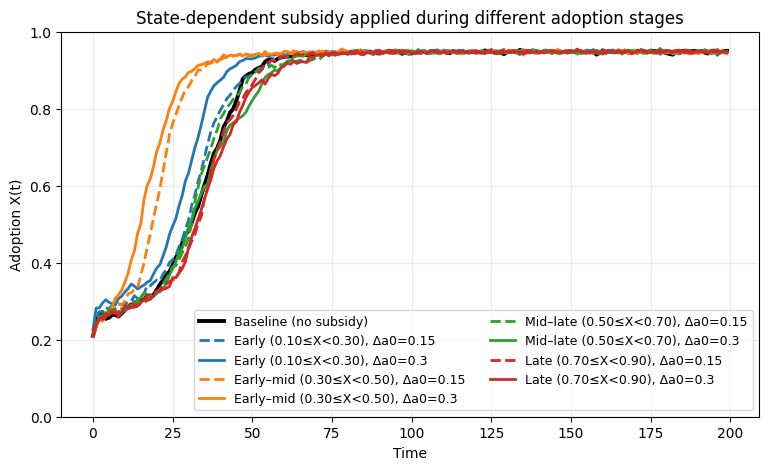

Saved to: plots/state_based_subsidy_lines_corrected.png
Baseline final X: 0.9502222222222223


In [38]:
# -------------------------------------------------
# 1) State-based subsidy policy factory
# -------------------------------------------------
def policy_subsidy_state_factory(
    *,
    x_low: float,
    x_high: float,
    delta_a0: float = 0.2,
    delta_beta_I: float = 0.0,
):
    """
    Subsidy is active only when the aggregate adoption X(t)
    lies within a predefined interval [x_low, x_high).
    This makes the policy state-dependent rather than time-based.
    """
    def policy(model, step):
        # Store baseline parameters once to ensure reversibility
        if not hasattr(policy, "base_a0"):
            policy.base_a0 = model.a0
        if not hasattr(policy, "base_beta_I"):
            policy.base_beta_I = model.beta_I

        # Read current adoption level
        if hasattr(model, "get_adoption_fraction"):
            x = float(model.get_adoption_fraction())
        else:
            # Fallback: try to read last recorded X from datacollector
            try:
                df = model.datacollector.get_model_vars_dataframe()
                x = float(df["X"].iloc[-1])
            except Exception:
                x = 0.0

        # Apply subsidy only inside the specified adoption window
        if x_low <= x < x_high:
            model.a0 = policy.base_a0 + delta_a0
            model.beta_I = policy.base_beta_I + delta_beta_I
        else:
            model.a0 = policy.base_a0
            model.beta_I = policy.base_beta_I

    return policy


# -------------------------------------------------
# 2) Helper: run multiple trials with a given policy
# -------------------------------------------------
def collect_trials_with_custom_policy(
    *,
    n_trials: int,
    T: int,
    scenario_kwargs: dict,
    policy_func,
    seed_base: int = 100,
    strategy_choice_func: str = "logit",
    tau: float = 2.0,
):
    """
    Runs multiple stochastic trials and returns
    the mean adoption trajectory X(t).
    """
    X_list = []
    for i in range(n_trials):
        seed = seed_base + i
        X, I, _ = run_timeseries_trial(
            T=T,
            scenario_kwargs=scenario_kwargs,
            seed=seed,
            policy=policy_func,
            strategy_choice_func=strategy_choice_func,
            tau=tau,
        )
        X_list.append(X)

    mat = np.vstack(X_list)
    return mat.mean(axis=0)


# -------------------------------------------------
# 3) Scenario close to tipping (to make timing matter)
# -------------------------------------------------
T = 200
n_trials = 30
seed_base = 100
strategy_choice_func = "logit"
tau = 2.0  # smoother response to payoff differences

scenario = dict(
    ratio=1.6,          # close to tipping
    beta_I=2.0,
    b=1.0,
    g_I=0.10,
    I0=0.05,
    network_type="BA",
    n_nodes=300,
    m=2,
    p=0.05,
    X0_frac=0.10,       # lower initial adoption so baseline does not reach full adoption
    init_method="random",
)


# -------------------------------------------------
# 4) Define state-based subsidy windows and intensities
# -------------------------------------------------
# Adoption intervals are chosen so that they do not overlap
# with the initial condition and meaningfully separate
# early, intermediate, and late diffusion phases.
policies = {
    "Early (0.10≤X<0.30)": (0.10, 0.30),
    "Early–mid (0.30≤X<0.50)": (0.30, 0.50),
    "Mid–late (0.50≤X<0.70)": (0.50, 0.70),
    "Late (0.70≤X<0.90)": (0.70, 0.90),
}

# Two subsidy strengths to compare timing versus intensity
intensities = [0.15, 0.30]

colors = {
    "Early (0.10≤X<0.30)": "C0",
    "Early–mid (0.30≤X<0.50)": "C1",
    "Mid–late (0.50≤X<0.70)": "C2",
    "Late (0.70≤X<0.90)": "C3",
}
linestyles = {0.15: "--", 0.30: "-"}


# -------------------------------------------------
# 5) Run baseline and policy scenarios
# -------------------------------------------------
t = np.arange(T)

plt.figure(figsize=(9, 5))

# Baseline: no subsidy applied
baseline_mean = collect_trials_with_custom_policy(
    n_trials=n_trials,
    T=T,
    scenario_kwargs=scenario,
    policy_func=None,
    seed_base=seed_base,
    strategy_choice_func=strategy_choice_func,
    tau=tau,
)
plt.plot(
    t,
    baseline_mean,
    color="black",
    linewidth=2.8,
    label="Baseline (no subsidy)",
)

# State-dependent subsidy policies
for name, (x_low, x_high) in policies.items():
    for da0 in intensities:
        pol = policy_subsidy_state_factory(
            x_low=x_low,
            x_high=x_high,
            delta_a0=da0,
        )
        mean_curve = collect_trials_with_custom_policy(
            n_trials=n_trials,
            T=T,
            scenario_kwargs=scenario,
            policy_func=pol,
            seed_base=seed_base,
            strategy_choice_func=strategy_choice_func,
            tau=tau,
        )
        plt.plot(
            t,
            mean_curve,
            color=colors[name],
            linestyle=linestyles[da0],
            linewidth=2.0,
            label=f"{name}, Δa0={da0}",
        )

plt.xlabel("Time")
plt.ylabel("Adoption X(t)")
plt.title("State-dependent subsidy applied during different adoption stages")
plt.ylim(0, 1)
plt.grid(alpha=0.25)
plt.legend(ncol=2, fontsize=9)

out_path = "plots/state_based_subsidy_lines_corrected.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved to:", out_path)
print("Baseline final X:", float(baseline_mean[-1]))


ratio=1.45 -> baseline final X=0.490
ratio=1.50 -> baseline final X=0.908
ratio=1.55 -> baseline final X=0.948
ratio=1.60 -> baseline final X=0.947
ratio=1.65 -> baseline final X=0.950

Chosen ratio for plotting: 1.5


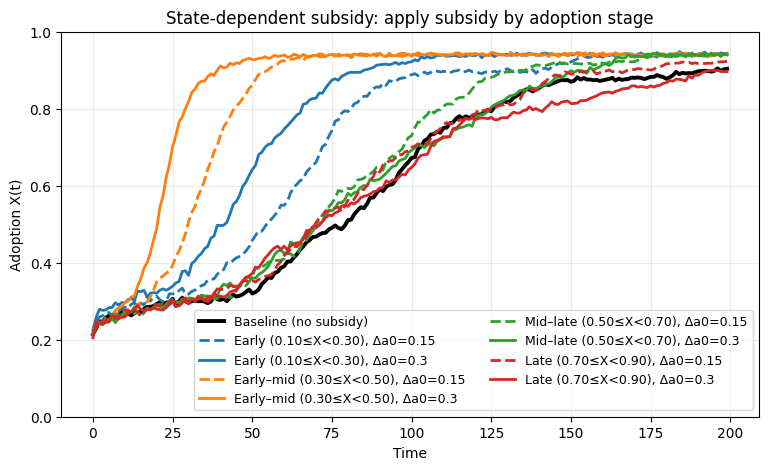

Saved to: plots/state_based_subsidy_lines_tuned_baseline.png
Baseline final X: 0.9038888888888886


In [40]:
# -------------------------------------------------
# State-dependent subsidies (same visual style as before)
# Only tune baseline conditions so baseline does NOT go to ~100%
# -------------------------------------------------

# 1) Core settings (same as your earlier plot)
T = 200
n_trials = 30
seed_base = 100
strategy_choice_func = "logit"
tau = 2.0

# 2) Keep "strong enough" feedback so policies can matter
#    (Only adjust ratio to place baseline just below tipping)
scenario_base = dict(
    ratio=None,         # we'll set this after a quick sweep
    beta_I=2.0,
    b=1.0,
    g_I=0.10,
    I0=0.05,
    network_type="BA",
    n_nodes=300,
    m=2,
    p=0.05,
    X0_frac=0.10,
    init_method="random",
)

# 3) Subsidy windows (your preferred non-overlapping stages)
policies = {
    "Early (0.10≤X<0.30)": (0.10, 0.30),
    "Early–mid (0.30≤X<0.50)": (0.30, 0.50),
    "Mid–late (0.50≤X<0.70)": (0.50, 0.70),
    "Late (0.70≤X<0.90)": (0.70, 0.90),
}
intensities = [0.15, 0.30]
colors = {
    "Early (0.10≤X<0.30)": "C0",
    "Early–mid (0.30≤X<0.50)": "C1",
    "Mid–late (0.50≤X<0.70)": "C2",
    "Late (0.70≤X<0.90)": "C3",
}
linestyles = {0.15: "--", 0.30: "-"}

# -------------------------------------------------
# 4) Quick baseline calibration: choose a ratio that does NOT reach ~1.0
# -------------------------------------------------
candidate_ratios = [1.45, 1.50, 1.55, 1.60, 1.65]
target_baseline_final = 0.70  # aim for "not full adoption" but not too low either

baseline_finals = []
for r in candidate_ratios:
    scenario = dict(scenario_base)
    scenario["ratio"] = r
    baseline_mean = collect_trials_with_custom_policy(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario,
        policy_func=None,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    baseline_finals.append(float(baseline_mean[-1]))
    print(f"ratio={r:.2f} -> baseline final X={baseline_finals[-1]:.3f}")

# pick ratio closest to target (but still < 0.95 so it's clearly not "almost full")
best_idx = None
best_score = 1e9
for i, xf in enumerate(baseline_finals):
    if xf < 0.95:
        score = abs(xf - target_baseline_final)
        if score < best_score:
            best_score = score
            best_idx = i

# fallback if everything is >=0.95 (rare): pick smallest ratio
if best_idx is None:
    best_idx = int(np.argmin(candidate_ratios))

best_ratio = candidate_ratios[best_idx]
print("\nChosen ratio for plotting:", best_ratio)

# -------------------------------------------------
# 5) Run baseline + policies with the chosen ratio and plot (LINES ONLY)
# -------------------------------------------------
scenario = dict(scenario_base)
scenario["ratio"] = best_ratio

t = np.arange(T)
plt.figure(figsize=(9, 5))

# Baseline (no subsidy)
baseline_mean = collect_trials_with_custom_policy(
    n_trials=n_trials,
    T=T,
    scenario_kwargs=scenario,
    policy_func=None,
    seed_base=seed_base,
    strategy_choice_func=strategy_choice_func,
    tau=tau,
)
plt.plot(t, baseline_mean, color="black", linewidth=2.8, label="Baseline (no subsidy)")

# Policies
for name, (x_low, x_high) in policies.items():
    for da0 in intensities:
        pol = policy_subsidy_state_factory(x_low=x_low, x_high=x_high, delta_a0=da0)
        mean_curve = collect_trials_with_custom_policy(
            n_trials=n_trials,
            T=T,
            scenario_kwargs=scenario,
            policy_func=pol,
            seed_base=seed_base,
            strategy_choice_func=strategy_choice_func,
            tau=tau,
        )
        plt.plot(
            t,
            mean_curve,
            color=colors[name],
            linestyle=linestyles[da0],
            linewidth=2.0,
            label=f"{name}, Δa0={da0}",
        )

plt.xlabel("Time")
plt.ylabel("Adoption X(t)")
plt.title("State-dependent subsidy: apply subsidy by adoption stage")
plt.ylim(0, 1)
plt.grid(alpha=0.25)
plt.legend(ncol=2, fontsize=9)

out_path = "plots/state_based_subsidy_lines_tuned_baseline.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved to:", out_path)
print("Baseline final X:", float(baseline_mean[-1]))


# Experiment runner #

Heatmap: Final doption vs X0,I0

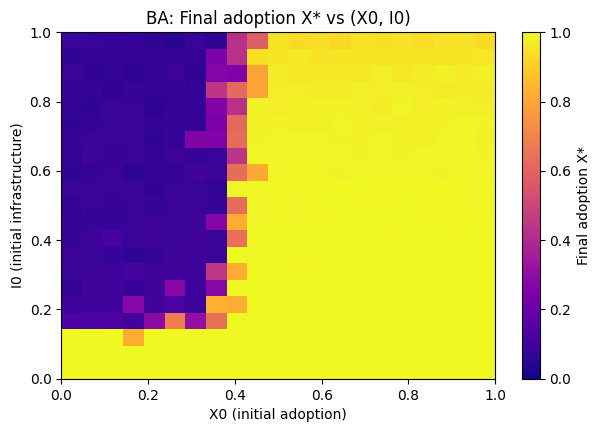

Saved to: plots/heatmap_X0_I0_BA.png
Min X*: 0.05 Max X*: 1.0


In [33]:
def heatmap_Xstar_X0_I0(
    X0_values,
    I0_values,
    *,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.10,
    T=200,
    batch_size=5,
    network_type="BA",
    n_nodes=200,
    p=0.05,
    m=2,
    tau=1.0
):
    X0_values = list(X0_values)
    I0_values = list(I0_values)
    H = np.zeros((len(I0_values), len(X0_values)), dtype=float)

    for i, I0 in enumerate(I0_values):
        for j, X0 in enumerate(X0_values):
            finals = []
            for _ in range(batch_size):
                seed = np.random.randint(0, 2**31 - 1)
                x_star = run_network_trial(
                    X0_frac=float(X0),
                    ratio=float(ratio),
                    I0=float(I0),
                    beta_I=float(beta_I),
                    b=float(b),
                    g_I=float(g_I),
                    T=int(T),
                    network_type=str(network_type),
                    n_nodes=int(n_nodes),
                    p=float(p),
                    m=int(m),
                    seed=int(seed),
                    collect=False,
                    strategy_choice_func="logit",
                    tau=float(tau),
                )
                finals.append(x_star)
            H[i, j] = float(np.mean(finals))

    return np.asarray(X0_values, dtype=float), np.asarray(I0_values, dtype=float), H


def plot_heatmap_X0_I0(X0_vals, I0_vals, H, title="Final adoption X* vs (X0, I0)", out_path=None):
    fig, ax = plt.subplots(figsize=(7, 4.5))
    im = ax.imshow(
        H,
        origin="lower",
        extent=[X0_vals[0], X0_vals[-1], I0_vals[0], I0_vals[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    fig.colorbar(im, ax=ax, label="Final adoption X*")
    ax.set_xlabel("X0 (initial adoption)")
    ax.set_ylabel("I0 (initial infrastructure)")
    ax.set_title(title)

    if out_path is not None:
        fig.savefig(out_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close(fig)


# ---- RUN ----
X0_vals = np.linspace(0.0, 1.0, 21)
I0_vals = np.linspace(0.0, 1.0, 21)

X0v, I0v, H = heatmap_Xstar_X0_I0(
    X0_vals,
    I0_vals,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.10,
    T=200,
    batch_size=5,
    network_type="BA",
    n_nodes=200,
    p=0.05,
    m=2,
    tau=1.0
)

plot_heatmap_X0_I0(X0v, I0v, H, title="BA: Final adoption X* vs (X0, I0)",
                   out_path="plots/heatmap_X0_I0_BA.png")

print("Saved to: plots/heatmap_X0_I0_BA.png")
print("Min X*:", float(H.min()), "Max X*:", float(H.max()))


Phase plot trajectory: I(t) vs X(t)

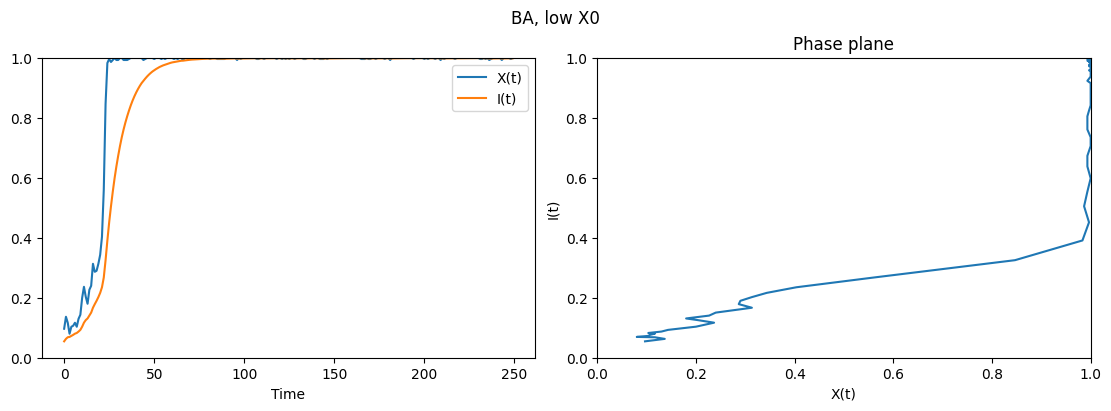

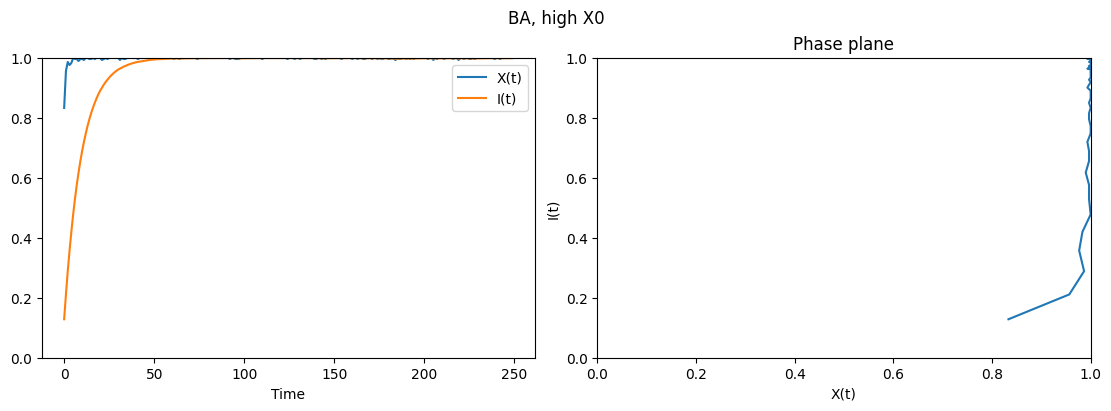

In [37]:
def plot_phase_trajectory_from_trial(X, I, title="Phase trajectory (I vs X)"):
    t = np.arange(len(X))
    fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)

    axes[0].plot(t, X, label="X(t)")
    axes[0].plot(t, I, label="I(t)")
    axes[0].set_ylim(0, 1)
    axes[0].set_xlabel("Time")
    axes[0].legend()

    axes[1].plot(X, I)
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel("X(t)")
    axes[1].set_ylabel("I(t)")
    axes[1].set_title("Phase plane")

    fig.suptitle(title)
    plt.show()

scenario = dict(ratio=2.3, beta_I=2.0, b=1.0, g_I=0.10, I0=0.05,
                network_type="BA", n_nodes=300, m=2, p=0.05,
                X0_frac=0.10, init_method="random")
X, I, _ = run_timeseries_trial(T=250, scenario_kwargs=scenario, seed=1,
                               strategy_choice_func="logit", tau=1.0)
plot_phase_trajectory_from_trial(X, I, title="BA, low X0")

scenario["X0_frac"] = 0.50
X2, I2, _ = run_timeseries_trial(T=250, scenario_kwargs=scenario, seed=1,
                                 strategy_choice_func="logit", tau=1.0)
plot_phase_trajectory_from_trial(X2, I2, title="BA, high X0")


βI sensitivity curve

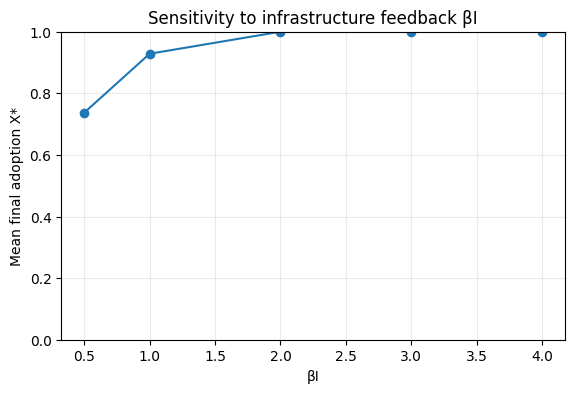

In [ ]:
def beta_sensitivity_curve(
    beta_values, *, X0_frac=0.30, I0=0.05, ratio=2.3,
    b=1.0, g_I=0.10, T=250, batch_size=10,
    network_type="BA", n_nodes=225, p=0.05, m=2, tau=1.0
):
    rows = []
    for beta_I in beta_values:
        finals = []
        for _ in range(batch_size):
            seed = np.random.randint(0, 2**31 - 1)
            finals.append(run_network_trial(
                X0_frac=X0_frac, ratio=ratio, I0=I0,
                beta_I=beta_I, b=b, g_I=g_I, T=T,
                network_type=network_type, n_nodes=n_nodes, p=p, m=m,
                seed=seed, collect=False, strategy_choice_func="logit", tau=tau
            ))
        rows.append((beta_I, float(np.mean(finals))))
    return pd.DataFrame(rows, columns=["beta_I", "X_star_mean"])

df_beta = beta_sensitivity_curve(beta_values=[0.5, 1.0, 2.0, 3.0, 4.0])
plt.figure(figsize=(6.5, 4))
plt.plot(df_beta["beta_I"], df_beta["X_star_mean"], marker="o")
plt.ylim(0, 1)
plt.xlabel("βI")
plt.ylabel("Mean final adoption X*")
plt.title("Sensitivity to infrastructure feedback βI")
plt.grid(alpha=0.25)
plt.savefig("plots/sensitivity_betaI.png", dpi=300, bbox_inches="tight")
plt.show()


# !!! Refreshing Core Codes for the Next Section to Avoid Error Spilling Over !!!

In [4]:
def choose_strategy_imitate(agent, neighbors):
    """Choose strategy of the highest-payoff neighbour (including self)."""
    candidates = neighbors + [agent]
    best = max(candidates, key=lambda a: a.payoff)
    return best.strategy

def choose_strategy_logit(agent, neighbors, a_I, b, tau):
    """Choose strategy using logit / softmax choice.

    Parameters
    - agent: the agent choosing a strategy
    - neighbors: list of neighbour agents
    - a_I: effective coordination payoff given current infrastructure
    - b: defection payoff
    - tau: temperature parameter for softmax
    """
    # compute expected payoffs for C and D 
    """ Still have to do determine C and D pi! """
    pi_C = 0.0
    pi_D = 0.0
    for other in neighbors:
        s_j = other.strategy
        if s_j == "C":
            pi_C += a_I
            pi_D += b
        else:
            pi_C += 0.0
            pi_D += b

    # softmax choice
    denom = np.exp(pi_C / tau) + np.exp(pi_D / tau)
    P_C = np.exp(pi_C / tau) / denom if denom > 0 else 0.5
    return "C" if random.random() < P_C else "D"

####################################
# Agent class
#
# The EVAgent class implements the single agent at a graph node.
#
# Attributes
# - strategy: "C" (adopt EV) or "D" (defect / ICE)
# - payoff: accumulated payoff from interactions with neighbours
# - next_strategy: strategy chosen for the next time step
####################################
class EVAgent(Agent):
    """Single agent at a graph node.

    Attributes
    - strategy: "C" (adopt EV) or "D" (defect / ICE)
    - payoff: accumulated payoff from interactions with neighbours
    - next_strategy: strategy chosen for the next time step
    """
# Initial conditions, runs when a new agent is created. Each agent starts with: a strategy (C/D), zero payoff and a next strategy based on neighbours
    def __init__(self, unique_id, model, init_strategy="D"):
        super().__init__(unique_id, model)
        self.strategy = init_strategy
        self.payoff = 0.0
        self.next_strategy = init_strategy
# Calculate payoff of current strategy 
    def step(self):
        """Compute payoff from interactions with neighbours.

        Stag Hunt payoff rules:
        - C vs C: `a_I` (coordination enhanced by infrastructure)
        - C vs D: 0
        - D vs C: `b`
        - D vs D: `b`
        """
        I = self.model.infrastructure           # Current infrastructure level
        a0 = self.model.a0                      # Base coordination payoff for EV adoption
        beta_I = self.model.beta_I              # Strength of infrastructure feedback
        b = self.model.b                        # payoff from sticking with ICE
        a_I = a0 + beta_I * I                   # effective payoff for EV–EV interaction

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))
        if not neighbor_agents:
            self.payoff = 0.0
            return

        payoff = 0.0
        for other in neighbor_agents:
            s_i = self.strategy
            s_j = other.strategy
            if s_i == "C" and s_j == "C":
                payoff += a_I
            elif s_i == "C" and s_j == "D":
                payoff += 0.0
            elif s_i == "D" and s_j == "C":
                payoff += b
            else:
                payoff += b
        self.payoff = payoff

    ####################################
    # Advance method
    #
    # The advance method updates the agent's strategy based on the selected rule.
    #
    # Parameters
    # - strategy_choice_func: the strategy selection function to use ("imitate" or "logit")
    ####################################

    def advance(self, strategy_choice_func="imitate"):
        """Update next_strategy using the selected rule.

        If called without an explicit rule, read `self.model.strategy_choice_func`.
        Commit `self.strategy = self.next_strategy` for synchronous updates.
        """
        func = strategy_choice_func if strategy_choice_func is not None else getattr(self.model, "strategy_choice_func", "imitate")

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))

        if func == "imitate":
            self.next_strategy = choose_strategy_imitate(self, neighbor_agents)
        elif func == "logit":
            a_I = self.model.a0 + self.model.beta_I * self.model.infrastructure
            self.next_strategy = choose_strategy_logit(self, neighbor_agents, a_I, self.model.b, getattr(self.model, "tau", 1.0))
        else:
            raise ValueError(f"Unknown strategy choice function: {func}")

        self.strategy = self.next_strategy

class EVStagHuntModel(Model):
    """Mesa model for EV Stag Hunt on a network."""

    def __init__(
        self,
        initial_ev=10, # - initial_ev: number of initial EV nodes
        a0=2.0, # - a0: base payoff for EV adoption
        beta_I=3.0, # - beta_I: payoff enhancement factor for EV adoption
        b=1.0, # - b: payoff for ICE defection
        g_I=0.1, # - g_I: infrastructure growth rate
        I0=0.05, # - I0: initial infrastructure level
        seed=42,
        network_type="random",
        n_nodes=100,
        p=0.05,
        m=2,
        k=30,
        collect=True,
        strategy_choice_func: str = "imitate",
        tau: float = 1.0,
    ):
        super().__init__(seed=seed)

        # Build graph
        if network_type == "BA":
            G = nx.barabasi_albert_graph(n_nodes, 15, seed=seed)

        elif network_type == "ER":
            G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)

        elif network_type == "WS":
            k = k if k % 2 == 0 else k + 1  # Ensure even for WS
            G = nx.watts_strogatz_graph(n=n_nodes, k=k, p=p, seed=seed)
        else:
            raise ValueError(f"Unknown network_type: {network_type}")

        self.G = G
        self.grid = NetworkGrid(G)
        self.schedule = SimultaneousActivation(self)

        # parameters
        self.a0 = a0
        self.beta_I = beta_I
        self.b = b
        self.g_I = g_I
        self.infrastructure = I0
        self.step_count = 0
        self.strategy_choice_func = strategy_choice_func
        self.tau = tau

        # initialize node attribute for agent reference
        for n in self.G.nodes:
            self.G.nodes[n]["agent"] = []

        # choose initial EV nodes
        total_nodes = self.G.number_of_nodes()
        k_ev = max(0, min(initial_ev, total_nodes))
        ev_nodes = set(self.random.sample(list(self.G.nodes), k_ev))

        # create one agent per node
        uid = 0
        for node in self.G.nodes:
            init_strategy = "C" if node in ev_nodes else "D"
            agent = EVAgent(uid, self, init_strategy)
            uid += 1
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        self.datacollector = None
        if collect:
            self.datacollector = DataCollector(
                model_reporters={
                    "X": self.get_adoption_fraction,
                    "I": lambda m: m.infrastructure,
                },
                agent_reporters={"strategy": "strategy", "payoff": "payoff"},
            )

    def get_adoption_fraction(self):
        agents = self.schedule.agents
        if not agents:
            return 0.0
        return sum(1 for a in agents if a.strategy == "C") / len(agents)

    # ####################
    # Model step function
    #
    # The step function advances the model by one time step.
    # It first advances all agents, then computes the adoption fraction and infrastructure level.
    # The infrastructure level is updated based on the adoption fraction and the infrastructure growth rate.
    # The updated infrastructure level is clipped to the interval [0, 1].
    # Finally, if data collection is enabled, the model and agent data are collected.
    #######################
    def step(self): 
        self.schedule.step() # advance all agents
        X = self.get_adoption_fraction() # compute adoption fraction after all agents have advanced
        I = self.infrastructure # infrastructure level before this step
        dI = self.g_I * (X - I) # infrastructure growth rate, impacted by adoption fraction
        self.infrastructure = float(min(1.0, max(0.0, I + dI))) # clip infrastructure level to [0, 1]
        if self.datacollector is not None:
            self.datacollector.collect(self) # collect data at the end of each step
        self.step_count += 1 # increment step count after data collection

#########################
#
# Set initial adopters
# 
# Parameters
# - model: the EVStagHuntModel instance
# - X0_frac: fraction of agents to initially choose EV adoption
# - method: method to choose initial adopters ("random" or "degree")
# - seed: random seed for reproducibility
# - high: whether to choose high or low degree nodes for "degree" method
###########################
def set_initial_adopters(model, X0_frac, method="random", seed=None, high=True):
    """Set a fraction of agents to EV adopters using different heuristics."""
    rng = np.random.default_rng(seed)
    agents = model.schedule.agents
    n = len(agents)
    k = int(round(X0_frac * n))

    for a in agents:
        a.strategy = "D"

    if k <= 0:
        return

    if method == "random":
        idx = rng.choice(n, size=k, replace=False)
        for i in idx:
            agents[i].strategy = "C"
        return

    if method == "degree":
        deg = dict(model.G.degree())
        ordered_nodes = sorted(deg.keys(), key=lambda u: deg[u], reverse=high)
        chosen = set(ordered_nodes[:k])
        for a in agents:
            if a.unique_id in chosen:
                a.strategy = "C"
        return

    raise ValueError(f"Unknown method: {method}")


# -----------------------------
# Ratio sweep helpers (computation-only)
# -----------------------------
#########################
#
# Run a single network trial
# 
# Parameters
# - X0_frac: fraction of agents to initially choose EV adoption
# - ratio: payoff ratio between EV and DC agents (a0 = ratio*b - beta_I*I0)
# - I0: initial infrastructure level
# - beta_I: cost of EV adoption relative to DC (beta_I*I0)
# - b: payoff of EV (b)
# - g_I: infrastructure growth rate (g_I)
# - T: number of time steps to run
# - network_type: type of network to generate ("random" or "BA")
# - n_nodes: number of nodes in the network
# - p: probability of edge creation in random network
# - m: number of edges to attach from a new node to existing nodes in BA network
# - seed: random seed for reproducibility
# - tol: tolerance for convergence check (default: 1e-3)
# - patience: number of steps to wait for convergence (default: 30)

def run_network_trial(
    X0_frac: float,
    ratio: float = 2.0,
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "ER",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    k: int = 30,
    seed: int | None = None,
    tol: float = 1e-3,
    patience: int = 30,
    collect: bool = True,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> float:
    """Run a single realisation and return final adoption fraction.

    Preserves the intended initial payoff ratio via a0 = ratio*b - beta_I*I0.
    Includes basic stability-based early stopping.
    """
    initial_ev = int(round(X0_frac * n_nodes))
    a0 = ratio * b - beta_I * I0

    model = EVStagHuntModel(
        initial_ev=initial_ev,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        k=k,
        collect=collect,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    stable_steps = 0
    prev_X = None
    prev_I = None
    for _ in range(T):
        model.step()
        X = model.get_adoption_fraction()
        I = model.infrastructure
        if prev_X is not None and prev_I is not None:
            if abs(X - prev_X) < tol and abs(I - prev_I) < tol:
                stable_steps += 1
            else:
                stable_steps = 0
        prev_X, prev_I = X, I
        if X in (0.0, 1.0) and stable_steps >= 10:
            break
        if stable_steps >= patience:
            break

    return model.get_adoption_fraction()

#########################
#
# Compute final mean adoption fraction vs ratio
# 
##########################
def final_mean_adoption_vs_ratio(
    X0_frac: float,
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> np.ndarray:
    """Compute mean final adoption across a sweep of ratio values.

    For each ratio, average over `batch_size` trials with jittered `I0` and seeds.
    Returns a numpy array of means aligned with `ratio_values` order.
    """
    ratios = list(ratio_values)
    means: List[float] = []
    for ratio in ratios:
        finals: List[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        means.append(float(np.mean(finals)))
    return np.asarray(means, dtype=float)

#########################
#
# Compute heatmap row for a fixed ratio
# 
##########################
def _row_for_I0_task(args: Dict) -> np.ndarray:
    """Top-level worker to compute one heatmap row for a fixed I0.

    Returns an array of mean final adoption across provided X0_values.
    """
    I0 = args["I0"]
    X0_values = args["X0_values"]
    beta_I = args["beta_I"]
    b = args["b"]
    g_I = args["g_I"]
    T = args["T"]
    network_type = args["network_type"]
    n_nodes = args["n_nodes"]
    p = args["p"]
    m = args["m"]
    batch_size = args["batch_size"]
    init_noise_I = args["init_noise_I"]
    strategy_choice_func = args["strategy_choice_func"]
    tau = args["tau"]

    row = np.empty(len(X0_values), dtype=float)
    for j, X0 in enumerate(X0_values):
        finals: List[float] = []
        for _ in range(batch_size):
            # Add small noise to I0 if desired
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac=X0,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        row[j] = float(np.mean(finals))
    return row

    
#########################
#
# Compute heatmap matrix for phase sweep
# 
##########################
def phase_sweep_X0_vs_I0(
    X0_values: Iterable[float],
    I0_values: Iterable[float],
    *,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 250,
    network_type: str = "BA",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    max_workers: int | None = None,
    backend: str = "process",
    seed: int = 42,
) -> np.ndarray:
    """Compute a heatmap of mean final adoption X* over (X0, I0).

    Returns an array of shape (len(I0_values), len(X0_values)), 
    rows = I0_values, columns = X0_values.
    """
    X0_values = list(X0_values)
    I0_values = list(I0_values)
    X_final = np.zeros((len(I0_values), len(X0_values)), dtype=float)

    # Prepare tasks per I0
    tasks: List[Dict] = []
    for I0 in I0_values:
        tasks.append({
            "I0": I0,
            "X0_values": X0_values,
            "beta_I": beta_I,
            "b": b,
            "g_I": g_I,
            "T": T,
            "network_type": network_type,
            "n_nodes": n_nodes,
            "p": p,
            "m": m,
            "batch_size": batch_size,
            "init_noise_I": init_noise_I,
            "strategy_choice_func": strategy_choice_func,
            "tau": tau,
            "seed": seed,
        })

    if max_workers is None:
        try:
            max_workers = os.cpu_count() or 1
        except Exception:
            max_workers = 1

    Executor = ProcessPoolExecutor if backend == "process" and max_workers > 1 else ThreadPoolExecutor
    if max_workers > 1:
        with Executor(max_workers=max_workers) as ex:
            futures = [ex.submit(_row_for_I0_task, args) for args in tasks]
            for i, fut in enumerate(futures):
                row = fut.result()
                X_final[i, :] = row
    else:
        for i, args in enumerate(tasks):
            row = _row_for_I0_task(args)
            X_final[i, :] = row

    return X_final

def _default_plot_path(filename: str) -> str:
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    return os.path.join(plots_dir, filename)


def plot_fanchart(traces_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot fan charts (quantile bands) for baseline vs subsidy using traces DF.

    traces_df columns: ['group', 'trial', 'time', 'X'] where group in {'baseline','subsidy'}.
    """
    if traces_df.empty:
        raise ValueError("traces_df is empty")

    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]

        # Compute quantiles by time across trials
        q = gdf.groupby("time")["X"].quantile([0.10, 0.25, 0.75, 0.90]).unstack(level=1)
        mean = gdf.groupby("time")["X"].mean()
        t = mean.index.to_numpy()

        ax = axes[0, j]
        ax.fill_between(t, q[0.10], q[0.90], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.15, label="10–90%")
        ax.fill_between(t, q[0.25], q[0.75], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.30, label="25–75%")

        # Overlay some traces for context (sample up to 100 trials)
        trial_ids = gdf["trial"].unique()
        rng = np.random.default_rng(123)
        sample = rng.choice(trial_ids, size=min(100, len(trial_ids)), replace=False)
        for tr in sample:
            tr_df = gdf[gdf["trial"] == tr]
            ax.plot(tr_df["time"], tr_df["X"], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.1, linewidth=0.8)

        ax.plot(t, mean, color=("steelblue" if group == "baseline" else "darkorange"), linewidth=2, label="mean")
        ax.set_title(f"{group.capitalize()} adoption")
        ax.set_xlabel("Time")
        ax.set_ylabel("X(t)")
        ax.set_ylim(0, 1)
        ax.legend(loc="lower right")

        # Final X(T) histogram
        t_max = int(gdf["time"].max())
        final_vals = gdf[gdf["time"] == t_max].groupby("trial")["X"].mean().to_numpy()
        axes[1, j].hist(final_vals, bins=20, color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.8)
        axes[1, j].set_title(f"{group.capitalize()} final X(T)")
        axes[1, j].set_xlabel("X(T)")
        axes[1, j].set_ylabel("Count")

    if out_path is None:
        out_path = _default_plot_path("ev_intervention_fanchart.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_spaghetti(traces_df: pd.DataFrame, *, max_traces: int = 100, alpha: float = 0.15, out_path: Optional[str] = None) -> str:
    """Spaghetti plot from traces DF for baseline vs subsidy."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)
    rng = np.random.default_rng(123)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        trial_ids = gdf["trial"].unique()
        sample = rng.choice(trial_ids, size=min(max_traces, len(trial_ids)), replace=False)
        ax = axes[j]
        for tr in sample:
            tr_df = gdf[gdf["trial"] == tr]
            ax.plot(tr_df["time"], tr_df["X"], color=("steelblue" if group == "baseline" else "darkorange"), alpha=alpha, linewidth=0.8)
        ax.set_title(f"{group.capitalize()} traces")
        ax.set_xlabel("Time")
        ax.set_ylabel("X(t)")
        ax.set_ylim(0, 1)

    if out_path is None:
        out_path = _default_plot_path("ev_spaghetti.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_density(traces_df: pd.DataFrame, *, x_bins: int = 50, time_bins: Optional[int] = None, out_path: Optional[str] = None) -> str:
    """Time-evolving density plot (2D histogram) from traces DF."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        T = int(gdf["time"].max()) + 1
        if time_bins is None:
            bins_time = T
        else:
            bins_time = time_bins
        hb = axes[j].hist2d(gdf["time"].to_numpy(), gdf["X"].to_numpy(), bins=[bins_time, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
        axes[j].set_title(f"{group.capitalize()} density: time vs X(t)")
        axes[j].set_xlabel("Time")
        axes[j].set_ylabel("X(t)")
        fig.colorbar(hb[3], ax=axes[j], label="count")

    if out_path is None:
        out_path = _default_plot_path("ev_density.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_ratio_sweep(sweep_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot X* vs ratio from a DataFrame with columns ['ratio','X_mean']."""
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(sweep_df["ratio"], sweep_df["X_mean"], color="C0", lw=2)
    ax.set_xlabel("a_I / b (ratio)")
    ax.set_ylabel("Final adoption X*")
    ax.set_title("X* vs ratio")
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.25)
    if out_path is None:
        out_path = _default_plot_path("ev_ratio_sweep.png")
    fig.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close(fig)
    return out_path


def plot_phase_plot(phase_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot heatmap from tidy DataFrame with columns ['X0','ratio','X_final']."""
    # Pivot to matrix for imshow
    pivot = phase_df.pivot(index="ratio", columns="X0", values="X_final").sort_index().sort_index(axis=1)
    ratios = pivot.index.to_numpy()
    X0s = pivot.columns.to_numpy()

    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        pivot.to_numpy(),
        origin="lower",
        extent=[X0s[0], X0s[-1], ratios[0], ratios[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("a_I / b (initial payoff ratio)")
    plt.title("Network phase plot: X* over X0 and a_I/b")

    # Overlay threshold X = 1/ratio
    X_thresh = 1.0 / ratios
    X_thresh_clipped = np.clip(X_thresh, 0.0, 1.0)
    plt.plot(X_thresh_clipped, ratios, color="white", linestyle="--", linewidth=1.5, label="X = b / a_I (initial)")
    plt.legend(loc="upper right")

    if out_path is None:
        out_path = _default_plot_path("ev_phase_plot.png")
    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()
    return out_path

# Sweeping X0 & Plotting X0 Against Final Adoption

In [39]:
def final_mean_adoption_vs_X0(
    X0_frac_values: Iterable[float],
    *,
    ratio: float = 2.0,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    k: int = 30,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
    seed: int = 42,
) -> np.ndarray:
    """Compute mean final adoption across a sweep of initial X0 fractions.

    For each X0_frac, average over `batch_size` trials with jittered `I0` and seeds.
    Returns a numpy array of means aligned with `X0_frac_values` order.
    """
    X0_fracs = list(X0_frac_values)
    means: list[float] = []
    for X0_frac in X0_fracs:
        finals: list[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                k=k,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        means.append(float(np.mean(finals)))
    return np.asarray(means, dtype=float)

def X0_sweep_df(
    X0_frac: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    T: int = 250,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    seed: int = 42,
) -> pd.DataFrame:
    """Compute X* vs ratio and return as a DataFrame."""
    scenario = {
        "ratio": 2.0,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "I0": 0.05,
        "network_type": "random",
        "n_nodes": 200,
        "p": 0.05,
        "m": 2,
        "k": 30,
        "seed": 42,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    X_means = final_mean_adoption_vs_X0(
        X0_frac,
        ratio=scenario["ratio"],
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed=seed,
    )

    return pd.DataFrame({"X0": X0_frac, "X_mean": X_means})

def plot_X0_sweep(df, out_path=None):
    X0_values = df["X0"]
    X_means = df["X_mean"]

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(X0_values, X_means, lw=2)

    ax.set_xlabel("Initial adoption X0")
    ax.set_ylabel("Final adoption X*")
    ax.set_title("X* vs initial adoption X0")
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.25)

    if out_path is None:
        out_path = "ev_X0_sweep.png"

    fig.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close(fig)
    return out_path



Defining Parameters for X0 Sweep for Each Network

In [35]:
ER_X0_df = X0_sweep_df(
    X0_frac= np.linspace(0.2, 0.9, 20, dtype= float),
    scenario_kwargs= {
        "ratio": 2.0,
        "beta_I": 1.5,
        "b": 2.0,
        "g_I": 0.05,
        "I0": 0.1,
        "network_type": "ER",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,},
    T = 250,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed= 42,
)

ER_X0_df

,X0,X_mean
0,0.200000,0.000000
1,0.236842,0.000000
2,0.273684,0.000000
3,0.310526,0.000000
4,0.347368,0.025417
5,0.384211,0.366875
6,0.421053,0.502500
7,0.457895,0.783958
8,0.494737,0.956875
9,0.531579,1.000000


In [29]:
BA_X0_df = X0_sweep_df(
    X0_frac= np.linspace(0.2, 0.9, 20, dtype= float),
    scenario_kwargs= {
        "ratio": 2.0,
        "beta_I": 1.5,
        "b": 2.0,
        "g_I": 0.05,
        "I0": 0.1,
        "network_type": "BA",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,},
    T = 250,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed= 42,
)

BA_X0_df

,X0,X_mean
0,0.200000,0.096667
1,0.236842,0.093542
2,0.273684,0.097083
3,0.310526,0.095000
4,0.347368,0.098958
5,0.384211,0.101250
6,0.421053,0.094792
7,0.457895,0.197292
8,0.494737,0.642292
9,0.531579,0.866667


In [40]:
WS_X0_df = X0_sweep_df(
    X0_frac= np.linspace(0.2, 0.9, 20, dtype= float),
    scenario_kwargs= {
        "ratio": 2.0,
        "beta_I": 1.5,
        "b": 2.0,
        "g_I": 0.05,
        "I0": 0.1,
        "network_type": "WS",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,
        "k": 30,},
    T = 250,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed= 42,
)

WS_X0_df

,X0,X_mean
0,0.200000,0.0000
1,0.236842,0.0000
2,0.273684,0.0000
3,0.310526,0.0000
4,0.347368,0.3125
5,0.384211,0.6250
6,0.421053,1.0000
7,0.457895,1.0000
8,0.494737,1.0000
9,0.531579,1.0000


In [ ]:
"Plotting ER_X0_df"
plot_X0_sweep(ER_X0_df, out_path="ER1_X0_sweep.png")
"Plotting BA_X0_df"
plot_X0_sweep(BA_X0_df, out_path="BA1_X0_sweep.png")
"Plotting WS_X0_df"
plot_X0_sweep(WS_X0_df, out_path="WS1_X0_sweep.png")

'BA1_X0_sweep.png'

# Sweeping I0 & Plotting I0 Against Final Adoption

In [20]:
def final_mean_adoption_vs_I0(
    X0_frac: float = 0.05,
    I0_values: Optional[Iterable[float]] = None,
    *,
    ratio: float = 1.0,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "ER",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
    seed: int = 42,
) -> np.ndarray:
    """Compute mean final adoption across a sweep of initial infrastructure I0 values.

    For each I0, average over `batch_size` trials with jittered I0 and seeds.
    Returns a numpy array of means aligned with `I0_values` order.
    """
    I0_list = list(I0_values)
    means: list[float] = []
    for I0_val in I0_list:
        finals: list[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0_val, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        means.append(float(np.mean(finals)))
    return np.asarray(means, dtype=float)

def I0_sweep_df(
    X0_frac: float = 0.40,
    I0_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    T: int = 250,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    seed: int= 42,
):
    """Compute X* vs I0 and return DataFrame."""
    scenario = {
        "ratio": 2.0,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
        "seed": 42,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    if I0_values is None:
        I0_values = np.linspace(0.0, 0.6, 31)

    X_means = final_mean_adoption_vs_I0(
        X0_frac,
        I0_values,
        ratio=scenario["ratio"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed=seed,
    )

    return pd.DataFrame({"I0": I0_values, "X_mean": X_means})

def plot_I0_sweep(df, out_path=None):
    I0_values = df["I0"]
    X_means = df["X_mean"]

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(I0_values, X_means, lw=2)

    ax.set_xlabel("Initial infrastructure I0")
    ax.set_ylabel("Final adoption X*")
    ax.set_title("X* vs infrastructure I0 ")
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.25)

    if out_path is None:
        out_path = "ev_I0_sweep.png"

    fig.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close(fig)
    return out_path


Defining Parameters for I0 Sweep for Each Network

In [ ]:
ER_I0_df = I0_sweep_df(
    X0_frac = 0.40,
    I0_values = np.linspace(0.2, 0.9, 20, dtype= float),
    scenario_kwargs= {
        "ratio": 2.0,
        "beta_I": 1.5,
        "b": 2.0,
        "g_I": 0.05,
        "network_type": "ER",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,
        "seed": 42,},
    T = 250,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed=42,
)

ER_I0_df

In [21]:
BA_I0_df = I0_sweep_df(
    X0_frac = 0.40,
    I0_values = np.linspace(0.2, 0.9, 20, dtype= float),
    scenario_kwargs= {
        "ratio": 2.0,
        "beta_I": 1.5,
        "b": 2.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,},
    T = 250,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed=42,
)

BA_I0_df

KeyboardInterrupt: 

In [22]:
WS_I0_df = I0_sweep_df(
    X0_frac = 0.40,
    I0_values = np.linspace(0.2, 0.9, 20, dtype= float),
    scenario_kwargs= {
        "ratio": 2.0,
        "beta_I": 1.5,
        "b": 2.0,
        "g_I": 0.05,
        "network_type": "WS",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,
        "k": 30,},
    T = 250,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed=42,
)

WS_I0_df

,I0,X_mean
0,0.200000,0.0625
1,0.236842,0.0625
2,0.273684,0.1250
3,0.310526,0.2500
4,0.347368,0.1250
5,0.384211,0.0000
6,0.421053,0.0625
7,0.457895,0.0625
8,0.494737,0.0000
9,0.531579,0.1875


In [ ]:
"Plotting ER_I0_df"
plot_I0_sweep(ER_I0_df, out_path="ER1_I0_sweep.png")
"Plotting BA_I0_df"
plot_I0_sweep(BA_I0_df, out_path="BA1_I0_sweep.png")
"Plotting WS_I0_df"
plot_I0_sweep(WS_I0_df, out_path="WS1_I0_sweep.png")

# Sweeping BetaI & Plotting BetaI Against Final Adoption

In [ ]:
def final_mean_adoption_vs_betaI(
    X0_frac: float = 0.05,
    I0: float = 0.05,
    betaI_values: Iterable[float] = None,
    *,
    ratio: float = 1.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "ER",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
    seed: int = 42,
) -> np.ndarray:
    """Compute mean final adoption across a sweep of beta_I values."""

    if betaI_values is None:
        betaI_values = np.linspace(0.0, 5.0, 21)  # default range if not provided

    betaI_list = list(betaI_values)
    means: list[float] = []

    for beta_I_val in betaI_list:
        finals: list[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I_val,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        means.append(float(np.mean(finals)))

    return np.asarray(means, dtype=float)

def betaI_sweep_df(
    X0_frac: float = 0.40,
    I0: float = 0.05,
    betaI_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    T: int = 250,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    seed: int = 42,
):
    """Compute X* vs beta_I and return DataFrame."""

    scenario = {
        "ratio": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    if betaI_values is None:
        betaI_values = np.linspace(0.0, 5.0, 21)

    X_means = final_mean_adoption_vs_betaI(
        X0_frac,
        I0,
        betaI_values,
        ratio=scenario["ratio"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed=seed,
    )

    return pd.DataFrame({"beta_I": betaI_values, "X_mean": X_means})

def plot_BetaI_sweep(df, out_path=None):
    betaI_values = df["beta_I"]
    X_means = df["X_mean"]

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(betaI_values, X_means, lw=2)

    ax.set_xlabel("Infrastructure feedback strength βI")
    ax.set_ylabel("Final adoption X*")
    ax.set_title("X* vs infrastructure feedback strength βI")
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.25)

    if out_path is None:
        out_path = "ev_betaI_sweep.png"

    fig.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close(fig)
    return out_path

Defining Parameters for BetaI Sweep for Each Network

In [ ]:
ER_BetaI_df = betaI_sweep_df(
    X0_frac= 0.40,
    I0= 0.1,
    betaI_values= np.linspace(0.5, 9.0, 20, dtype= float),
    scenario_kwargs={
        "ratio": 2.0,
        "b": 2.0,
        "g_I": 0.05,
        "network_type": "ER",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,
        "k": 30,},
    T = 250,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed=42,
)

ER_BetaI_df

In [ ]:
BA_BetaI_df = betaI_sweep_df(
    X0_frac= 0.40,
    I0= 0.1,
    betaI_values= np.linspace(0.5, 9.0, 20, dtype= float),
    scenario_kwargs={
        "ratio": 2.0,
        "b": 2.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,
        "k": 30,},
    T = 250,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed=42,
)

BA_BetaI_df

In [ ]:
WS_BetaI_df = betaI_sweep_df(
    X0_frac= 0.40,
    I0= 0.1,
    betaI_values= np.linspace(0.5, 9.0, 20, dtype= float),
    scenario_kwargs={
        "ratio": 2.0,
        "b": 2.0,
        "g_I": 0.05,
        "network_type": "WS",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,
        "k": 30,},
    T = 250,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed=42,
)

WS_BetaI_df

In [ ]:
"Plotting ER_BetaI_df"
plot_BetaI_sweep(ER_BetaI_df, out_path="ER1_BetaI_sweep.png")
"Plotting BA_BetaI_df"
plot_BetaI_sweep(BA_BetaI_df, out_path="BA1_BetaI_sweep.png")
"Plotting WS_BetaI_df"
plot_BetaI_sweep(WS_BetaI_df, out_path="WS1_BetaI_sweep.png")

# !!! Refreshing Core Codes for the Next Section to Avoid Error Spilling Over !!!

In [5]:
def choose_strategy_imitate(agent, neighbors):
    """Choose strategy of the highest-payoff neighbour (including self)."""
    candidates = neighbors + [agent]
    best = max(candidates, key=lambda a: a.payoff)
    return best.strategy


def choose_strategy_logit(agent, neighbors, a_I, b, tau):
    """Choose strategy using logit / softmax choice.

    Parameters
    - agent: the agent choosing a strategy
    - neighbors: list of neighbour agents
    - a_I: effective coordination payoff given current infrastructure
    - b: defection payoff
    - tau: temperature parameter for softmax
    """
    # compute expected payoffs for C and D
    pi_C = 0.0
    pi_D = 0.0
    for other in neighbors:
        s_j = other.strategy
        if s_j == "C":
            pi_C += a_I
            pi_D += b
        else:
            pi_C += 0.0
            pi_D += b

    # softmax choice
    denom = np.exp(pi_C / tau) + np.exp(pi_D / tau)
    P_C = np.exp(pi_C / tau) / denom if denom > 0 else 0.5
    return "C" if random.random() < P_C else "D"



####################################
# Agent class
#
# The EVAgent class implements the single agent at a graph node.
#
# Attributes
# - strategy: "C" (adopt EV) or "D" (defect / ICE)
# - payoff: accumulated payoff from interactions with neighbours
# - next_strategy: strategy chosen for the next time step
####################################
class EVAgent(Agent):
    """Single agent at a graph node.

    Attributes
    - strategy: "C" (adopt EV) or "D" (defect / ICE)
    - payoff: accumulated payoff from interactions with neighbours
    - next_strategy: strategy chosen for the next time step
    """

    def __init__(self, unique_id, model, init_strategy="D"):
        super().__init__(unique_id, model)
        self.strategy = init_strategy
        self.payoff = 0.0
        self.next_strategy = init_strategy

    def step(self):
        """Compute payoff from interactions with neighbours.

        Stag Hunt payoff rules:
        - C vs C: `a_I` (coordination enhanced by infrastructure)
        - C vs D: 0
        - D vs C: `b`
        - D vs D: `b`
        """
        I = self.model.infrastructure
        a0 = self.model.a0
        beta_I = self.model.beta_I
        b = self.model.b
        a_I = a0 + beta_I * I

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))
        if not neighbor_agents:
            self.payoff = 0.0
            return

        payoff = 0.0
        for other in neighbor_agents:
            s_i = self.strategy
            s_j = other.strategy
            if s_i == "C" and s_j == "C":
                payoff += a_I
            elif s_i == "C" and s_j == "D":
                payoff += 0.0
            elif s_i == "D" and s_j == "C":
                payoff += b
            else:
                payoff += b
        self.payoff = payoff

    ####################################
    # Advance method
    #
    # The advance method updates the agent's strategy based on the selected rule.
    #
    # Parameters
    # - strategy_choice_func: the strategy selection function to use ("imitate" or "logit")
    ####################################
    def advance(self, strategy_choice_func="imitate"):
        """Update next_strategy using the selected rule.

        If called without an explicit rule, read `self.model.strategy_choice_func`.
        Commit `self.strategy = self.next_strategy` for synchronous updates.
        """
        func = strategy_choice_func if strategy_choice_func is not None else getattr(self.model, "strategy_choice_func", "imitate")

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))

        if func == "imitate":
            self.next_strategy = choose_strategy_imitate(self, neighbor_agents)
        elif func == "logit":
            a_I = self.model.a0 + self.model.beta_I * self.model.infrastructure
            self.next_strategy = choose_strategy_logit(self, neighbor_agents, a_I, self.model.b, getattr(self.model, "tau", 1.0))
        else:
            raise ValueError(f"Unknown strategy choice function: {func}")

        self.strategy = self.next_strategy

    ####################################
    # Model class
    #
    # The EVStagHuntModel class implements the Mesa model for EV Stag Hunt on a network.
    #
    # Parameters
    # - initial_ev: number of initial EV nodes
    # - a0: base payoff for EV adoption
    # - beta_I: payoff enhancement factor for EV adoption
    # - b: payoff for ICE defection
    # - g_I: infrastructure growth rate
    # - I0: initial infrastructure level
    # - seed: random seed for reproducibility
    # - network_type: type of network to generate ("random" or "BA")
    # - n_nodes: number of nodes in the network
    # - p: probability of edge creation in random network
    # - m: number of edges to attach to new node in BA network
    # - collect: whether to collect agent and model-level data
    # - strategy_choice_func: strategy selection function ("imitate" or "logit")
    # - tau: temperature parameter for softmax choice (only used with "logit")
    ####################################
#
class EVStagHuntModel(Model):
    """Mesa model for EV Stag Hunt on a network."""

    def __init__(
        self,
        initial_ev=10,
        a0=2.0,
        beta_I=3.0,
        b=1.0,
        g_I=0.1,
        I0=0.05,
        seed=None,
        network_type="random",
        n_nodes=100,
        p=0.05,
        m=2,
        k=30,
        collect=True,
        strategy_choice_func: str = "imitate",
        tau: float = 1.0,
    ):
        super().__init__(seed=seed)

        # Build graph
        if network_type == "BA":
            G = nx.barabasi_albert_graph(n_nodes, m, seed=seed)
        elif network_type == "WS":
            G = nx.watts_strogatz_graph(n_nodes, k=k, p=p, seed=seed)
        else:
            G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
        self.G = G
        self.grid = NetworkGrid(G)
        self.schedule = SimultaneousActivation(self)

        # parameters
        self.a0 = a0
        self.beta_I = beta_I
        self.b = b
        self.g_I = g_I
        self.infrastructure = I0
        self.step_count = 0
        self.strategy_choice_func = strategy_choice_func
        self.tau = tau

        # initialize node attribute for agent reference
        for n in self.G.nodes:
            self.G.nodes[n]["agent"] = []

        # choose initial EV nodes
        total_nodes = self.G.number_of_nodes()
        k_ev = max(0, min(initial_ev, total_nodes))
        ev_nodes = set(self.random.sample(list(self.G.nodes), k_ev))

        # create one agent per node
        uid = 0
        for node in self.G.nodes:
            init_strategy = "C" if node in ev_nodes else "D"
            agent = EVAgent(uid, self, init_strategy)
            uid += 1
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        self.datacollector = None
        if collect:
            self.datacollector = DataCollector(
                model_reporters={
                    "X": self.get_adoption_fraction,
                    "I": lambda m: m.infrastructure,
                },
                agent_reporters={"strategy": "strategy", "payoff": "payoff"},
            )

    def get_adoption_fraction(self):
        agents = self.schedule.agents
        if not agents:
            return 0.0
        return sum(1 for a in agents if a.strategy == "C") / len(agents)

    # ####################
    # Model step function
    #
    # The step function advances the model by one time step.
    # It first advances all agents, then computes the adoption fraction and infrastructure level.
    # The infrastructure level is updated based on the adoption fraction and the infrastructure growth rate.
    # The updated infrastructure level is clipped to the interval [0, 1].
    # Finally, if data collection is enabled, the model and agent data are collected.
    #######################
    def step(self): 
        self.schedule.step() # advance all agents
        X = self.get_adoption_fraction() # compute adoption fraction after all agents have advanced
        I = self.infrastructure # infrastructure level before this step
        dI = self.g_I * (X - I) # infrastructure growth rate, impacted by adoption fraction
        self.infrastructure = float(min(1.0, max(0.0, I + dI))) # clip infrastructure level to [0, 1]
        if self.datacollector is not None:
            self.datacollector.collect(self) # collect data at the end of each step
        self.step_count += 1 # increment step count after data collection

#########################
#
# Set initial adopters
# 
# Parameters
# - model: the EVStagHuntModel instance
# - X0_frac: fraction of agents to initially choose EV adoption
# - method: method to choose initial adopters ("random" or "degree")
# - seed: random seed for reproducibility
# - high: whether to choose high or low degree nodes for "degree" method
###########################
def set_initial_adopters(model, X0_frac, method="random", seed=None, high=True):
    """Set a fraction of agents to EV adopters using different heuristics."""
    rng = np.random.default_rng(seed)
    agents = model.schedule.agents
    n = len(agents)
    k = int(round(X0_frac * n))

    for a in agents:
        a.strategy = "D"

    if k <= 0:
        return

    if method == "random":
        idx = rng.choice(n, size=k, replace=False)
        for i in idx:
            agents[i].strategy = "C"
        return

    if method == "degree":
        deg = dict(model.G.degree())
        ordered_nodes = sorted(deg.keys(), key=lambda u: deg[u], reverse=high)
        chosen = set(ordered_nodes[:k])
        for a in agents:
            if a.unique_id in chosen:
                a.strategy = "C"
        return

    raise ValueError(f"Unknown method: {method}")


# -----------------------------
# Ratio sweep helpers (computation-only)
# -----------------------------
#########################
#
# Run a single network trial
# 
# Parameters
# - X0_frac: fraction of agents to initially choose EV adoption
# - ratio: payoff ratio between EV and DC agents (a0 = ratio*b - beta_I*I0)
# - I0: initial infrastructure level
# - beta_I: cost of EV adoption relative to DC (beta_I*I0)
# - b: payoff of EV (b)
# - g_I: infrastructure growth rate (g_I)
# - T: number of time steps to run
# - network_type: type of network to generate ("random" or "BA")
# - n_nodes: number of nodes in the network
# - p: probability of edge creation in random network
# - m: number of edges to attach from a new node to existing nodes in BA network
# - seed: random seed for reproducibility
# - tol: tolerance for convergence check (default: 1e-3)
# - patience: number of steps to wait for convergence (default: 30)

def run_network_trial(
    X0_frac: float,
    ratio: float,
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    k: int = 30,
    seed: int | None = None,
    tol: float = 1e-3,
    patience: int = 30,
    collect: bool = False,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> float:
    """Run a single realisation and return final adoption fraction.

    Preserves the intended initial payoff ratio via a0 = ratio*b - beta_I*I0.
    Includes basic stability-based early stopping.
    """
    initial_ev = int(round(X0_frac * n_nodes))
    a0 = ratio * b - beta_I * I0

    model = EVStagHuntModel(
        initial_ev=initial_ev,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        k=k,
        collect=collect,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    stable_steps = 0
    prev_X = None
    prev_I = None
    for _ in range(T):
        model.step()
        X = model.get_adoption_fraction()
        I = model.infrastructure
        if prev_X is not None and prev_I is not None:
            if abs(X - prev_X) < tol and abs(I - prev_I) < tol:
                stable_steps += 1
            else:
                stable_steps = 0
        prev_X, prev_I = X, I
        if X in (0.0, 1.0) and stable_steps >= 10:
            break
        if stable_steps >= patience:
            break

    return model.get_adoption_fraction()

#########################
#
# Compute final mean adoption fraction vs ratio
# 
##########################
def final_mean_adoption_vs_ratio(
    X0_frac: float,
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    k: int = 30,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> np.ndarray:
    """Compute mean final adoption across a sweep of ratio values.

    For each ratio, average over `batch_size` trials with jittered `I0` and seeds.
    Returns a numpy array of means aligned with `ratio_values` order.
    """
    ratios = list(ratio_values)
    means: List[float] = []
    for ratio in ratios:
        finals: List[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                k=k,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        means.append(float(np.mean(finals)))
    return np.asarray(means, dtype=float)

#########################
#
# Compute heatmap row for a fixed ratio
# 
##########################
def _row_for_ratio_task(args: Dict) -> np.ndarray:
    """Top-level worker to compute one heatmap row for a fixed ratio.

    Returns an array of mean final adoption across provided X0_values.
    """
    ratio = args["ratio"]
    X0_values = args["X0_values"]
    I0 = args["I0"]
    beta_I = args["beta_I"]
    b = args["b"]
    g_I = args["g_I"]
    T = args["T"]
    network_type = args["network_type"]
    n_nodes = args["n_nodes"]
    p = args["p"]
    m = args["m"]
    k = args["k"]
    batch_size = args["batch_size"]
    init_noise_I = args["init_noise_I"]
    strategy_choice_func = args["strategy_choice_func"]
    tau = args["tau"]

    row = np.empty(len(X0_values), dtype=float)
    for j, X0 in enumerate(X0_values):
        finals: List[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac=X0,
                ratio=ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                k=k,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        row[j] = float(np.mean(finals))
    return row

    
#########################
#
# Compute heatmap matrix for phase sweep
# 
##########################
def phase_sweep_X0_vs_ratio(
    X0_values: Iterable[float],
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 250,
    network_type: str = "BA",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    k: int = 30,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    max_workers: int | None = None,
    backend: str = "process",
) -> np.ndarray:
    """Compute a heatmap matrix of mean final adoption X* over (X0, ratio).

    Returns an array of shape (len(ratio_values), len(X0_values)) aligned with
    the provided orders. Rows correspond to ratios; columns to X0 values.
    """
    X0_values = list(X0_values)
    ratio_values = list(ratio_values)
    X_final = np.zeros((len(ratio_values), len(X0_values)), dtype=float)

    # Prepare tasks per ratio
    tasks: List[Dict] = []
    for ratio in ratio_values:
        tasks.append({
            "ratio": ratio,
            "X0_values": X0_values,
            "I0": I0,
            "beta_I": beta_I,
            "b": b,
            "g_I": g_I,
            "T": T,
            "network_type": network_type,
            "n_nodes": n_nodes,
            "p": p,
            "m": m,
            "k": k,
            "batch_size": batch_size,
            "init_noise_I": init_noise_I,
            "strategy_choice_func": strategy_choice_func,
            "tau": tau,
        })

    if max_workers is None:
        try:
            max_workers = os.cpu_count() or 1
        except Exception:
            max_workers = 1

    Executor = ProcessPoolExecutor if backend == "process" and max_workers > 1 else ThreadPoolExecutor
    if max_workers > 1:
        with Executor(max_workers=max_workers) as ex:
            futures = [ex.submit(_row_for_ratio_task, args) for args in tasks]
            for i, fut in enumerate(futures):
                row = fut.result()
                X_final[i, :] = row
    else:
        for i, args in enumerate(tasks):
            row = _row_for_ratio_task(args)
            X_final[i, :] = row

    return X_final

def _default_plot_path(filename: str) -> str:
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    return os.path.join(plots_dir, filename)


def plot_fanchart(traces_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot fan charts (quantile bands) for baseline vs subsidy using traces DF.

    traces_df columns: ['group', 'trial', 'time', 'X'] where group in {'baseline','subsidy'}.
    """
    if traces_df.empty:
        raise ValueError("traces_df is empty")

    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]

        # Compute quantiles by time across trials
        q = gdf.groupby("time")["X"].quantile([0.10, 0.25, 0.75, 0.90]).unstack(level=1)
        mean = gdf.groupby("time")["X"].mean()
        t = mean.index.to_numpy()

        ax = axes[0, j]
        ax.fill_between(t, q[0.10], q[0.90], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.15, label="10–90%")
        ax.fill_between(t, q[0.25], q[0.75], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.30, label="25–75%")

        # Overlay some traces for context (sample up to 100 trials)
        trial_ids = gdf["trial"].unique()
        rng = np.random.default_rng(123)
        sample = rng.choice(trial_ids, size=min(100, len(trial_ids)), replace=False)
        for tr in sample:
            tr_df = gdf[gdf["trial"] == tr]
            ax.plot(tr_df["time"], tr_df["X"], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.1, linewidth=0.8)

        ax.plot(t, mean, color=("steelblue" if group == "baseline" else "darkorange"), linewidth=2, label="mean")
        ax.set_title(f"{group.capitalize()} adoption")
        ax.set_xlabel("Time")
        ax.set_ylabel("X(t)")
        ax.set_ylim(0, 1)
        ax.legend(loc="lower right")

        # Final X(T) histogram
        t_max = int(gdf["time"].max())
        final_vals = gdf[gdf["time"] == t_max].groupby("trial")["X"].mean().to_numpy()
        axes[1, j].hist(final_vals, bins=20, color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.8)
        axes[1, j].set_title(f"{group.capitalize()} final X(T)")
        axes[1, j].set_xlabel("X(T)")
        axes[1, j].set_ylabel("Count")

    if out_path is None:
        out_path = _default_plot_path("ev_intervention_fanchart.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_spaghetti(traces_df: pd.DataFrame, *, max_traces: int = 100, alpha: float = 0.15, out_path: Optional[str] = None) -> str:
    """Spaghetti plot from traces DF for baseline vs subsidy."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)
    rng = np.random.default_rng(123)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        trial_ids = gdf["trial"].unique()
        sample = rng.choice(trial_ids, size=min(max_traces, len(trial_ids)), replace=False)
        ax = axes[j]
        for tr in sample:
            tr_df = gdf[gdf["trial"] == tr]
            ax.plot(tr_df["time"], tr_df["X"], color=("steelblue" if group == "baseline" else "darkorange"), alpha=alpha, linewidth=0.8)
        ax.set_title(f"{group.capitalize()} traces")
        ax.set_xlabel("Time")
        ax.set_ylabel("X(t)")
        ax.set_ylim(0, 1)

    if out_path is None:
        out_path = _default_plot_path("ev_spaghetti.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_density(traces_df: pd.DataFrame, *, x_bins: int = 50, time_bins: Optional[int] = None, out_path: Optional[str] = None) -> str:
    """Time-evolving density plot (2D histogram) from traces DF."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        T = int(gdf["time"].max()) + 1
        if time_bins is None:
            bins_time = T
        else:
            bins_time = time_bins
        hb = axes[j].hist2d(gdf["time"].to_numpy(), gdf["X"].to_numpy(), bins=[bins_time, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
        axes[j].set_title(f"{group.capitalize()} density: time vs X(t)")
        axes[j].set_xlabel("Time")
        axes[j].set_ylabel("X(t)")
        fig.colorbar(hb[3], ax=axes[j], label="count")

    if out_path is None:
        out_path = _default_plot_path("ev_density.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_ratio_sweep(sweep_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot X* vs ratio from a DataFrame with columns ['ratio','X_mean']."""
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(sweep_df["ratio"], sweep_df["X_mean"], color="C0", lw=2)
    ax.set_xlabel("a_I / b (ratio)")
    ax.set_ylabel("Final adoption X*")
    ax.set_title("X* vs ratio")
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.25)
    if out_path is None:
        out_path = _default_plot_path("ev_ratio_sweep.png")
    fig.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close(fig)
    return out_path


def plot_phase_plot(phase_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot heatmap from tidy DataFrame with columns ['X0','ratio','X_final']."""
    # Pivot to matrix for imshow
    pivot = phase_df.pivot(index="ratio", columns="X0", values="X_final").sort_index().sort_index(axis=1)
    ratios = pivot.index.to_numpy()
    X0s = pivot.columns.to_numpy()

    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        pivot.to_numpy(),
        origin="lower",
        extent=[X0s[0], X0s[-1], ratios[0], ratios[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("a_I / b (initial payoff ratio)")
    plt.title("Network phase plot: X* over X0 and a_I/b")

    # Overlay threshold X = 1/ratio
    X_thresh = 1.0 / ratios
    X_thresh_clipped = np.clip(X_thresh, 0.0, 1.0)
    plt.plot(X_thresh_clipped, ratios, color="white", linestyle="--", linewidth=1.5, label="X = b / a_I (initial)")
    plt.legend(loc="upper right")

    if out_path is None:
        out_path = _default_plot_path("ev_phase_plot.png")
    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()
    return out_path

def policy_subsidy_factory(start: int, end: int, delta_a0: float = 0.3, delta_beta_I: float = 0.0) -> Callable:
    """Create a policy that temporarily boosts coordination payoffs.

    Raises `a0` and/or `beta_I` during `[start, end)` and reverts after.
    Returns a closure `policy(model, step)`.
    """

    def policy(model, step):
        if not hasattr(policy, "base_a0"):
            policy.base_a0 = model.a0
        if not hasattr(policy, "base_beta_I"):
            policy.base_beta_I = model.beta_I

        if start <= step < end:
            model.a0 = policy.base_a0 + delta_a0
            model.beta_I = policy.base_beta_I + delta_beta_I
        else:
            model.a0 = policy.base_a0
            model.beta_I = policy.base_beta_I

    return policy


def policy_infrastructure_boost_factory(start: int, boost: float = 0.2, once: bool = True) -> Callable:
    """Create a policy that injects infrastructure at a specific step."""

    def policy(model, step):
        if step < start:
            return
        if once:
            if not hasattr(policy, "done"):
                model.infrastructure = float(np.clip(model.infrastructure + boost, 0.0, 1.0))
                policy.done = True
        else:
            model.infrastructure = float(np.clip(model.infrastructure + boost, 0.0, 1.0))

    return policy


# -----------------------------
# Trial runner
# -----------------------------

def run_timeseries_trial(
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    seed: Optional[int] = None,
    policy: Optional[Callable] = None,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """Run a single simulation and return X(t), I(t), and the model dataframe."""

    scenario = {
        # Either provide `ratio` to pin the initial a_I/b, or explicit `a0`.
        # Defaults here mirror the classroom-friendly values.
        # If `ratio` is present, we compute `a0 = ratio*b - beta_I*I0`.
        "a0": 2.0,
        "ratio": None,
        "beta_I": 3.0,
        "b": 1.0,
        "g_I": 0.1,
        "I0": 0.05,
        "network_type": "random",
        "n_nodes": 100,
        "p": 0.05,
        "m": 2,
        "k": 30,
        "collect": True,
        "X0_frac": 0.0,
        "init_method": "random",
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    # Compute a0 from ratio if provided to preserve initial payoff ratio
    a0_for_model = scenario["a0"]
    if scenario.get("ratio") is not None:
        a0_for_model = float(scenario["ratio"]) * float(scenario["b"]) - float(scenario["beta_I"]) * float(scenario["I0"])

    model = EVStagHuntModel(
        a0=a0_for_model,
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        I0=scenario["I0"],
        seed=seed,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        k=scenario["k"],
        collect=True,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    if scenario.get("X0_frac", 0.0) > 0.0:
        set_initial_adopters(
            model,
            scenario["X0_frac"],
            method=scenario.get("init_method", "random"),
            seed=seed,
        )

    for t in range(T):
        if policy is not None:
            policy(model, t)
        model.step()

    df = model.datacollector.get_model_vars_dataframe().copy()
    return df["X"].to_numpy(), df["I"].to_numpy(), df


def _timeseries_trial_worker(args_dict: Dict) -> Tuple[np.ndarray, np.ndarray]:
    """Worker for parallel trials that reconstructs closures for policies."""
    T = args_dict["T"]
    scenario_kwargs = args_dict.get("scenario_kwargs", {})
    seed = args_dict.get("seed", None)
    policy_spec = args_dict.get("policy", None)
    strategy_choice_func = args_dict.get("strategy_choice_func", "imitate")
    tau = args_dict.get("tau", 1.0)

    policy = None
    if isinstance(policy_spec, dict):
        ptype = policy_spec.get("type")
        if ptype == "subsidy":
            policy = policy_subsidy_factory(**policy_spec["params"])
        elif ptype == "infrastructure":
            policy = policy_infrastructure_boost_factory(**policy_spec["params"])

    X, I, _df = run_timeseries_trial(
        T=T,
        scenario_kwargs=scenario_kwargs,
        seed=seed,
        policy=policy,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    return X, I


# -----------------------------
# Experiment: Intervention trials + plotting
# -----------------------------

def collect_intervention_trials(
    n_trials: int = 10,
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    subsidy_params: Optional[Dict] = None,
    max_workers: int = 1,
    seed_base: int = 42,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray], pd.DataFrame, pd.DataFrame]:
    """Run baseline and subsidy trials; return raw trajectories and summary dataframes."""

    scenario = scenario_kwargs or {}
    subsidy = subsidy_params or {"start": 30, "end": 80, "delta_a0": 0.3, "delta_beta_I": 0.0}

    baseline_args = []
    subsidy_args = []
    for i in range(n_trials):
        seed = seed_base + i
        baseline_args.append(
            {
                "T": T,
                "scenario_kwargs": scenario,
                "seed": seed,
                "policy": None,
                "strategy_choice_func": strategy_choice_func,
                "tau": tau,
            }
        )
        subsidy_args.append(
            {
                "T": T,
                "scenario_kwargs": scenario,
                "seed": seed,
                "policy": {"type": "subsidy", "params": subsidy},
                "strategy_choice_func": strategy_choice_func,
                "tau": tau,
            }
        )

    baseline_X, baseline_I = [], []
    subsidy_X, subsidy_I = [], []

    # Run sequentially or concurrently
    Executor = ThreadPoolExecutor if max_workers == 1 else ProcessPoolExecutor
    with Executor(max_workers=max_workers) as ex:
        baseline_futs = [ex.submit(_timeseries_trial_worker, args) for args in baseline_args]
        subsidy_futs = [ex.submit(_timeseries_trial_worker, args) for args in subsidy_args]
        for fut in as_completed(baseline_futs):
            X, I = fut.result()
            baseline_X.append(X)
            baseline_I.append(I)
        for fut in as_completed(subsidy_futs):
            X, I = fut.result()
            subsidy_X.append(X)
            subsidy_I.append(I)

    # Align order by seed (as_completed may scramble)
    baseline_X = sorted(baseline_X, key=lambda arr: tuple(arr))
    subsidy_X = sorted(subsidy_X, key=lambda arr: tuple(arr))

    # Summary stats
    def summarize(X_list: List[np.ndarray]) -> pd.DataFrame:
        mat = np.vstack(X_list)
        df = pd.DataFrame({
            "X_mean": mat.mean(axis=0),
            "X_med": np.median(mat, axis=0),
            "X_q10": np.quantile(mat, 0.10, axis=0),
            "X_q25": np.quantile(mat, 0.25, axis=0),
            "X_q75": np.quantile(mat, 0.75, axis=0),
            "X_q90": np.quantile(mat, 0.90, axis=0),
        })
        return df

    baseline_df = summarize(baseline_X)
    subsidy_df = summarize(subsidy_X)

    return baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df, subsidy_df


def traces_to_long_df(baseline_X: List[np.ndarray], subsidy_X: List[np.ndarray]) -> pd.DataFrame:
    """Convert trajectory lists to a tidy DataFrame: [group, trial, time, X]."""
    rows = []
    for trial, X in enumerate(baseline_X):
        for t, x in enumerate(X):
            rows.append(("baseline", trial, t, float(x)))
    for trial, X in enumerate(subsidy_X):
        for t, x in enumerate(X):
            rows.append(("subsidy", trial, t, float(x)))
    return pd.DataFrame(rows, columns=["group", "trial", "time", "X"])


def ratio_sweep_df(
    X0_frac: float = 0.40,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    T: int = 250,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> pd.DataFrame:
    """Compute X* vs ratio and return as a DataFrame."""
    scenario = {
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "I0": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
        "k": 30,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    X_means = final_mean_adoption_vs_ratio(
        X0_frac,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        k=scenario["k"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    return pd.DataFrame({"ratio": ratio_values, "X_mean": X_means})


def phase_sweep_df(
    max_workers: int | None = None,
    backend: str = "process",
    X0_values: Optional[np.ndarray] = None,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    T: int = 250,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> pd.DataFrame:
    """Compute tidy DataFrame of X* over (X0, ratio)."""
    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 21)
    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    scenario = {
        "I0": 0.05,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
        "k": 30,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    X_final = phase_sweep_X0_vs_ratio(
        X0_values,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        k=scenario["k"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        max_workers=max_workers or 1,
        backend=backend,
    )

    rows = []
    for i, X0 in enumerate(X0_values):
        for j, ratio in enumerate(ratio_values):
            rows.append((float(X0), float(ratio), float(X_final[j, i])))
    return pd.DataFrame(rows, columns=["X0", "ratio", "X_final"])


def plot_intervention_fanchart(
    baseline_X: List[np.ndarray],
    subsidy_X: List[np.ndarray],
    out_path: Optional[str] = None,
) -> str:
    """Plot fan charts for baseline and subsidy trials and save to file.

    Returns the file path to the saved image.
    """
    T = len(baseline_X[0]) if baseline_X else 0
    t = np.arange(T)

    def quantiles(X_list: List[np.ndarray]):
        mat = np.vstack(X_list)
        return {
            "mean": mat.mean(axis=0),
            "q10": np.quantile(mat, 0.10, axis=0),
            "q25": np.quantile(mat, 0.25, axis=0),
            "q75": np.quantile(mat, 0.75, axis=0),
            "q90": np.quantile(mat, 0.90, axis=0),
            "final": mat[:, -1],
        }

    bq = quantiles(baseline_X)
    sq = quantiles(subsidy_X)

    fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

    # Baseline fan chart
    ax = axes[0, 0]
    ax.fill_between(t, bq["q10"], bq["q90"], color="steelblue", alpha=0.15, label="10–90%")
    ax.fill_between(t, bq["q25"], bq["q75"], color="steelblue", alpha=0.30, label="25–75%")
    for X in baseline_X:
        ax.plot(t, X, color="steelblue", alpha=0.10, linewidth=1)
    ax.plot(t, bq["mean"], color="steelblue", linewidth=2, label="mean")
    ax.set_title("Baseline adoption")
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.set_ylim(0, 1)
    ax.legend(loc="lower right")

    # Subsidy fan chart
    ax = axes[0, 1]
    ax.fill_between(t, sq["q10"], sq["q90"], color="darkorange", alpha=0.15, label="10–90%")
    ax.fill_between(t, sq["q25"], sq["q75"], color="darkorange", alpha=0.30, label="25–75%")
    for X in subsidy_X:
        ax.plot(t, X, color="darkorange", alpha=0.10, linewidth=1)
    ax.plot(t, sq["mean"], color="darkorange", linewidth=2, label="mean")
    ax.set_title("Subsidy adoption")
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.set_ylim(0, 1)
    ax.legend(loc="lower right")

    # Histograms of final X(T)
    axes[1, 0].hist(bq["final"], bins=20, color="steelblue", alpha=0.8)
    axes[1, 0].set_title("Baseline final adoption X(T)")
    axes[1, 0].set_xlabel("X(T)")
    axes[1, 0].set_ylabel("Count")

    axes[1, 1].hist(sq["final"], bins=20, color="darkorange", alpha=0.8)
    axes[1, 1].set_title("Subsidy final adoption X(T)")
    axes[1, 1].set_xlabel("X(T)")
    axes[1, 1].set_ylabel("Count")

    # Save figure
    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_intervention_fanchart.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_spaghetti_traces(
    baseline_X: List[np.ndarray],
    subsidy_X: List[np.ndarray],
    *,
    max_traces: int = 100,
    alpha: float = 0.15,
    out_path: Optional[str] = None,
) -> str:
    """Plot raw trajectories as thin, transparent lines for baseline/subsidy.

    Shows bifurcation visually: many lines diverging toward 0 or 1 over time.
    """
    # Select random subset for visual clarity
    rng = np.random.default_rng(123)
    def subset(trajs: List[np.ndarray]) -> List[np.ndarray]:
        if len(trajs) <= max_traces:
            return trajs
        idx = rng.choice(len(trajs), size=max_traces, replace=False)
        return [trajs[i] for i in idx]

    b_sub = subset(baseline_X)
    s_sub = subset(subsidy_X)

    T = len(b_sub[0]) if b_sub else 0
    t = np.arange(T)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)

    ax = axes[0]
    for X in b_sub:
        ax.plot(t, X, color="steelblue", alpha=alpha, linewidth=0.8)
    ax.set_title("Baseline traces")
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.set_ylim(0, 1)

    ax = axes[1]
    for X in s_sub:
        ax.plot(t, X, color="darkorange", alpha=alpha, linewidth=0.8)
    ax.set_title("Subsidy traces")
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.set_ylim(0, 1)

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_spaghetti.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_time_evolving_density(
    baseline_X: List[np.ndarray],
    subsidy_X: List[np.ndarray],
    *,
    x_bins: int = 50,
    time_bins: Optional[int] = None,
    out_path: Optional[str] = None,
) -> str:
    """Plot 2D histograms of (time, X) densities for baseline and subsidy.

    X-axis: time, Y-axis: adoption X(t), Color: frequency/density of passes.
    """
    if not baseline_X or not subsidy_X:
        raise ValueError("Need non-empty baseline and subsidy trajectories")

    T = len(baseline_X[0])
    if time_bins is None:
        time_bins = T

    # Flatten (t, X) points across all trials
    def flatten_points(trajs: List[np.ndarray]):
        t = np.arange(T)
        t_all = np.repeat(t, len(trajs))
        x_all = np.hstack(trajs)
        return t_all, x_all

    bt, bx = flatten_points(baseline_X)
    st, sx = flatten_points(subsidy_X)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), constrained_layout=True)

    hb = axes[0].hist2d(bt, bx, bins=[time_bins, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
    axes[0].set_title("Baseline density: time vs X(t)")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("X(t)")
    fig.colorbar(hb[3], ax=axes[0], label="count")

    hs = axes[1].hist2d(st, sx, bins=[time_bins, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
    axes[1].set_title("Subsidy density: time vs X(t)")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("X(t)")
    fig.colorbar(hs[3], ax=axes[1], label="count")

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_density.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def run_ratio_sweep_plot(
    X0_frac: float = 0.40,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    T: int = 250,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    out_path: Optional[str] = None,
) -> str:
    """Sweep ratio values and plot final adoption X* vs a_I/b for a fixed X0.

    Calls the core computation helper and saves a simple line plot.
    Returns the path to the saved image.
    """
    scenario = {
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "I0": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
        "k": 30,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    X_means = final_mean_adoption_vs_ratio(
        X0_frac,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        k=scenario["k"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(ratio_values, X_means, color="tabblue" if hasattr(plt, "tabblue") else "C0", lw=2)
    ax.set_xlabel("a_I / b (ratio)")
    ax.set_ylabel("Final adoption X*")
    ax.set_title(f"X* vs ratio for X0={X0_frac:.2f}")
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.25)

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_ratio_sweep.png")
    fig.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close(fig)
    return out_path


def run_phase_plot_X0_vs_ratio_network(
    max_workers: int | None = None,
    backend: str = "process",
    X0_values: Optional[np.ndarray] = None,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    T: int = 250,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    out_path: Optional[str] = None,
):
    """Produce a heatmap of X* over (X0, a_I/b) using core sweep helper.

    Saves a figure similar to the original model script and returns the path.
    """
    # Defaults aligned with the original phase plot
    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 21)
    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    scenario = {
        "I0": 0.05,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
        "k": 30,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    X_final = phase_sweep_X0_vs_ratio(
        X0_values,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        k=scenario["k"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        max_workers=max_workers or 1,
        backend=backend,
    )

    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        X_final,
        origin="lower",
        extent=[X0_values[0], X0_values[-1], ratio_values[0], ratio_values[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("a_I / b (initial payoff ratio)")
    plt.title("Network phase plot: X* over X0 and a_I/b")

    # Overlay initial threshold X = b/a_I => X = 1/ratio
    X_thresh = 1.0 / ratio_values
    X_thresh_clipped = np.clip(X_thresh, 0.0, 1.0)
    plt.plot(
        X_thresh_clipped,
        ratio_values,
        color="white",
        linestyle="--",
        linewidth=1.5,
        label="X = b / a_I (initial)",
    )

    plt.legend(loc="upper right")

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_phase_plot.png")
    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()
    return out_path


def run_intervention_example(
    n_trials: int = 10,
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    subsidy_params: Optional[Dict] = None,
    max_workers: int = 1,
    seed_base: int = 42,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> Tuple[pd.DataFrame, pd.DataFrame, str]:
    """Convenience: collect trials, plot, and return summary + image path."""

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df, subsidy_df = collect_intervention_trials(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario_kwargs,
        subsidy_params=subsidy_params,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    # Use DataFrame-based plotting to ensure outputs go to plots/
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    img_path = plot_fanchart(traces_df)
    return baseline_df, subsidy_df, img_path


# -----------------------------
# CLI Entrypoint
# -----------------------------

def main():
    # Defaults aligned with original ev_stag_mesa_model.run_intervention_example
    n_trials = 30  # use fewer than 500 for speed while keeping shape
    T = 200
    strategy_choice_func = "logit"
    tau = 1.0
    max_workers = 1
    seed_base = 100

    scenario = dict(
        # Preserve initial ratio by computing a0 from ratio, matching the original
        ratio=2.3,
        beta_I=2.0,
        b=1.0,
        g_I=0.10,
        I0=0.05,
        network_type="BA",
        n_nodes=300,
        m=2,
        collect=True,
        X0_frac=0.40,
        init_method="random",
        # ER-specific `p` ignored for BA but kept for completeness
        p=0.05,
        k=30,
    )
    subsidy = dict(start=10, end=60, delta_a0=0.4, delta_beta_I=0.0)

    baseline_df, subsidy_df, img_path = run_intervention_example(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    print("Baseline DF shape:", baseline_df.shape)
    print("Subsidy DF shape:", subsidy_df.shape)
    print("Saved image:", img_path)
    print("Baseline final X_mean:", float(baseline_df["X_mean"].iloc[-1]))
    print("Subsidy  final X_mean:", float(subsidy_df["X_mean"].iloc[-1]))

    # Also run the phase plot of X* over (X0, a_I/b) and save it
    phase_df = phase_sweep_df(
        max_workers=1,
        backend="thread",
        X0_values=np.linspace(0.0, 1.0, 21),
        ratio_values=np.linspace(0.8, 3.5, 31),
        batch_size=8,
        T=200,
        strategy_choice_func="logit",
        tau=1.0,
    )
    phase_path = plot_phase_plot(phase_df)
    print("Saved phase plot:", phase_path)

    # Spaghetti and time-evolving density plots
    # Use a larger trial count for clearer trace/density visuals
    n_trials_spaghetti = 100
    T_spaghetti = 200

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df2, subsidy_df2 = collect_intervention_trials(
        n_trials=n_trials_spaghetti,
        T=T_spaghetti,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    spaghetti_path = plot_spaghetti(traces_df, max_traces=100, alpha=0.15)
    print("Saved spaghetti plot:", spaghetti_path)

    density_path = plot_density(traces_df, x_bins=50, time_bins=T_spaghetti)
    print("Saved time-evolving density plot:", density_path)

    # Ratio sweep computed to DF then plotted
    sweep_df = ratio_sweep_df(
        X0_frac=scenario.get("X0_frac", 0.40),
        ratio_values=np.linspace(0.8, 3.5, 31),
        scenario_kwargs=scenario,
        T=200,
        batch_size=8,
        strategy_choice_func="logit",
        tau=1.0,
    )
    sweep_path = plot_ratio_sweep(sweep_df)
    print("Saved ratio sweep plot:", sweep_path)

# Generating X0-Payoff Ratio Heatmaps & Spaghetti Plots for Each Network

In [ ]:
# ER

def main():
    # Defaults aligned with original ev_stag_mesa_model.run_intervention_example
    n_trials = 30  # use fewer than 500 for speed while keeping shape
    T = 200
    strategy_choice_func = "logit"
    tau = 1.0
    max_workers = 1
    seed_base = 100

    scenario = dict(
        # Preserve initial ratio by computing a0 from ratio, matching the original
        ratio=2.0,
        beta_I=1.5,
        b=2.0,
        g_I=0.05,
        I0=0.1,
        network_type="ER",
        n_nodes=300,
        m=2,
        collect=True,
        X0_frac=0.40,
        init_method="random",
        # ER-specific `p` ignored for BA but kept for completeness
        p=0.1,
    )
    subsidy = dict(start=10, end=60, delta_a0=0.4, delta_beta_I=0.0)

    baseline_df, subsidy_df, img_path = run_intervention_example(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    print("Baseline DF shape:", baseline_df.shape)
    print("Subsidy DF shape:", subsidy_df.shape)
    print("Saved image:", img_path)
    print("Baseline final X_mean:", float(baseline_df["X_mean"].iloc[-1]))
    print("Subsidy  final X_mean:", float(subsidy_df["X_mean"].iloc[-1]))

    # Also run the phase plot of X* over (X0, a_I/b) and save it
    phase_df = phase_sweep_df(
        max_workers=1,
        backend="thread",
        X0_values=np.linspace(0.0, 1.0, 21),
        ratio_values=np.linspace(0.8, 3.5, 31),
        batch_size=8,
        T=200,
        strategy_choice_func="logit",
        tau=1.0,
    )
    phase_path = plot_phase_plot(phase_df)
    print("Saved phase plot:", phase_path)

    # Spaghetti and time-evolving density plots
    # Use a larger trial count for clearer trace/density visuals
    n_trials_spaghetti = 100
    T_spaghetti = 200

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df2, subsidy_df2 = collect_intervention_trials(
        n_trials=n_trials_spaghetti,
        T=T_spaghetti,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    spaghetti_path = plot_spaghetti(traces_df, max_traces=100, alpha=0.15)
    print("Saved spaghetti plot:", spaghetti_path)

    density_path = plot_density(traces_df, x_bins=50, time_bins=T_spaghetti)
    print("Saved time-evolving density plot:", density_path)

    # Ratio sweep computed to DF then plotted
    sweep_df = ratio_sweep_df(
        X0_frac=scenario.get("X0_frac", 0.40),
        ratio_values=np.linspace(0.8, 3.5, 31),
        scenario_kwargs=scenario,
        T=200,
        batch_size=8,
        strategy_choice_func="logit",
        tau=1.0,
    )
    sweep_path = plot_ratio_sweep(sweep_df)
    print("Saved ratio sweep plot:", sweep_path)

if __name__ == "__main__":
    main()

Baseline DF shape: (200, 6)
Subsidy DF shape: (200, 6)
Saved image: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Decision-Making\Assignment_3\plots\ev_intervention_fanchart.png
Baseline final X_mean: 0.23655555555555557
Subsidy  final X_mean: 0.23655555555555557
Saved phase plot: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Decision-Making\Assignment_3\plots\ev_phase_plot.png
Saved spaghetti plot: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Decision-Making\Assignment_3\plots\ev_spaghetti.png
Saved time-evolving density plot: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Decision-Making\Assignment_3\plots\ev_density.png
Saved ratio sweep plot: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Deci

In [ ]:
# BA

def main():
    # Defaults aligned with original ev_stag_mesa_model.run_intervention_example
    n_trials = 30  # use fewer than 500 for speed while keeping shape
    T = 200
    strategy_choice_func = "logit"
    tau = 1.0
    max_workers = 1
    seed_base = 100

    scenario = dict(
        # Preserve initial ratio by computing a0 from ratio, matching the original
        ratio=2.0,
        beta_I=1.5,
        b=2.0,
        g_I=0.05,
        I0=0.1,
        network_type="BA",
        n_nodes=300,
        m=2,
        collect=True,
        X0_frac=0.40,
        init_method="random",
        # ER-specific `p` ignored for BA but kept for completeness
        p=0.1,
    )
    subsidy = dict(start=10, end=60, delta_a0=0.4, delta_beta_I=0.0)

    baseline_df, subsidy_df, img_path = run_intervention_example(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    print("Baseline DF shape:", baseline_df.shape)
    print("Subsidy DF shape:", subsidy_df.shape)
    print("Saved image:", img_path)
    print("Baseline final X_mean:", float(baseline_df["X_mean"].iloc[-1]))
    print("Subsidy  final X_mean:", float(subsidy_df["X_mean"].iloc[-1]))

    # Also run the phase plot of X* over (X0, a_I/b) and save it
    phase_df = phase_sweep_df(
        max_workers=1,
        backend="thread",
        X0_values=np.linspace(0.0, 1.0, 21),
        ratio_values=np.linspace(0.8, 3.5, 31),
        batch_size=8,
        T=200,
        strategy_choice_func="logit",
        tau=1.0,
    )
    phase_path = plot_phase_plot(phase_df)
    print("Saved phase plot:", phase_path)

    # Spaghetti and time-evolving density plots
    # Use a larger trial count for clearer trace/density visuals
    n_trials_spaghetti = 100
    T_spaghetti = 200

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df2, subsidy_df2 = collect_intervention_trials(
        n_trials=n_trials_spaghetti,
        T=T_spaghetti,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    spaghetti_path = plot_spaghetti(traces_df, max_traces=100, alpha=0.15)
    print("Saved spaghetti plot:", spaghetti_path)

    density_path = plot_density(traces_df, x_bins=50, time_bins=T_spaghetti)
    print("Saved time-evolving density plot:", density_path)

    # Ratio sweep computed to DF then plotted
    sweep_df = ratio_sweep_df(
        X0_frac=scenario.get("X0_frac", 0.40),
        ratio_values=np.linspace(0.8, 3.5, 31),
        scenario_kwargs=scenario,
        T=200,
        batch_size=8,
        strategy_choice_func="logit",
        tau=1.0,
    )
    sweep_path = plot_ratio_sweep(sweep_df)
    print("Saved ratio sweep plot:", sweep_path)

if __name__ == "__main__":
    main()

In [6]:
# WS

def main():
    # Defaults aligned with original ev_stag_mesa_model.run_intervention_example
    n_trials = 30  # use fewer than 500 for speed while keeping shape
    T = 200
    strategy_choice_func = "logit"
    tau = 1.0
    max_workers = 1
    seed_base = 100

    scenario = dict(
        # Preserve initial ratio by computing a0 from ratio, matching the original
        ratio=2.0,
        beta_I=1.5,
        b=2.0,
        g_I=0.05,
        I0=0.1,
        network_type="WS",
        n_nodes=300,
        m=2,
        k=30,
        collect=True,
        X0_frac=0.40,
        init_method="random",
        # ER-specific `p` ignored for BA but kept for completeness
        p=0.1,
    )
    subsidy = dict(start=10, end=60, delta_a0=0.4, delta_beta_I=0.0)

    baseline_df, subsidy_df, img_path = run_intervention_example(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    print("Baseline DF shape:", baseline_df.shape)
    print("Subsidy DF shape:", subsidy_df.shape)
    print("Saved image:", img_path)
    print("Baseline final X_mean:", float(baseline_df["X_mean"].iloc[-1]))
    print("Subsidy  final X_mean:", float(subsidy_df["X_mean"].iloc[-1]))

    # Also run the phase plot of X* over (X0, a_I/b) and save it
    phase_df = phase_sweep_df(
        max_workers=1,
        backend="thread",
        X0_values=np.linspace(0.0, 1.0, 21),
        ratio_values=np.linspace(0.8, 3.5, 31),
        batch_size=8,
        T=200,
        strategy_choice_func="logit",
        tau=1.0,
    )
    phase_path = plot_phase_plot(phase_df)
    print("Saved phase plot:", phase_path)

    # Spaghetti and time-evolving density plots
    # Use a larger trial count for clearer trace/density visuals
    n_trials_spaghetti = 100
    T_spaghetti = 200

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df2, subsidy_df2 = collect_intervention_trials(
        n_trials=n_trials_spaghetti,
        T=T_spaghetti,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    spaghetti_path = plot_spaghetti(traces_df, max_traces=100, alpha=0.15)
    print("Saved spaghetti plot:", spaghetti_path)

    density_path = plot_density(traces_df, x_bins=50, time_bins=T_spaghetti)
    print("Saved time-evolving density plot:", density_path)

    # Ratio sweep computed to DF then plotted
    sweep_df = ratio_sweep_df(
        X0_frac=scenario.get("X0_frac", 0.40),
        ratio_values=np.linspace(0.8, 3.5, 31),
        scenario_kwargs=scenario,
        T=200,
        batch_size=8,
        strategy_choice_func="logit",
        tau=1.0,
    )
    sweep_path = plot_ratio_sweep(sweep_df)
    print("Saved ratio sweep plot:", sweep_path)

if __name__ == "__main__":
    main()

Baseline DF shape: (200, 6)
Subsidy DF shape: (200, 6)
Saved image: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Decision-Making\Assignment_3\plots\ev_intervention_fanchart.png
Baseline final X_mean: 0.9
Subsidy  final X_mean: 0.9
Saved phase plot: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Decision-Making\Assignment_3\plots\ev_phase_plot.png
Saved spaghetti plot: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Decision-Making\Assignment_3\plots\ev_spaghetti.png
Saved time-evolving density plot: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Decision-Making\Assignment_3\plots\ev_density.png
Saved ratio sweep plot: c:\Users\aryew\OneDrive\文档\Master's Complex Systems & Policy\Model-Based Decision Making\Lab-Model-Based-Decision-Making\Assignment_3\plots\e

# Evaluating & Plotting Adoption Speed

C:\Users\aryew\AppData\Local\Temp\ipykernel_11420\978460507.py:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


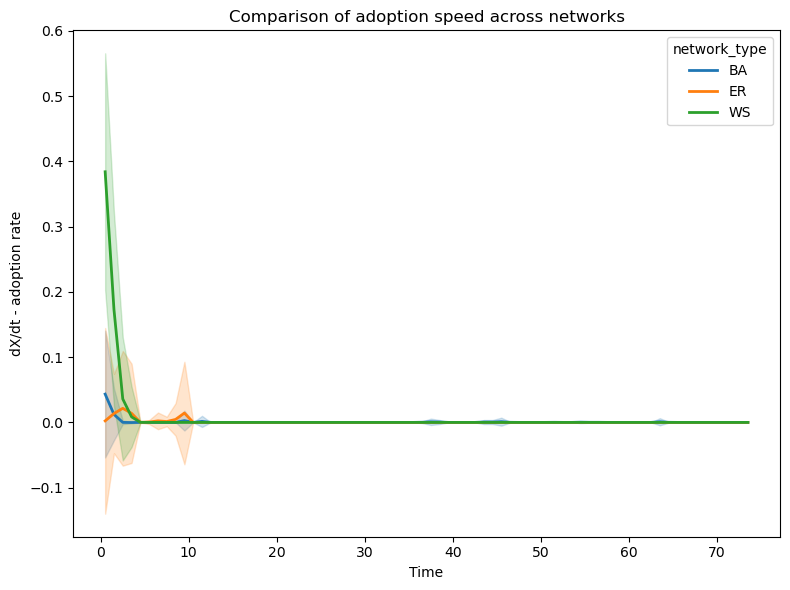

In [47]:
# --- Helper: convert list of X(t) arrays into tidy DataFrame with network type ---
def traces_to_long_df_networks(baseline_X_dict):
    """
    Convert trajectories for multiple networks to tidy DataFrame:
    [network_type, trial, time, X]
    baseline_X_dict : dict
        Keys = network type string, values = list of np.ndarray trajectories
    """
    rows = []
    for net_type, X_list in baseline_X_dict.items():
        for trial, X in enumerate(X_list):
            for t, x in enumerate(X):
                rows.append((net_type, trial, t, float(x)))
    return pd.DataFrame(rows, columns=["network_type", "trial", "time", "X"])


# --- Helper: compute dX/dt safely ---
def compute_dx_dt_safe(traces_df):
    dx_dt_list = []
    for (net_type, trial_id), df_trial in traces_df.groupby(["network_type", "trial"]):
        df_trial = df_trial.sort_values("time").drop_duplicates("time")
        X = df_trial["X"].values
        t = df_trial["time"].values
        dt = np.diff(t)
        dX = np.diff(X)
        with np.errstate(divide='ignore', invalid='ignore'):
            dXdt = np.where(dt != 0, dX/dt, 0)
        t_mid = (t[:-1] + t[1:]) / 2
        dx_dt_list.append(pd.DataFrame({
            "network_type": net_type,
            "trial": trial_id,
            "time": t_mid,
            "dX_dt": dXdt
        }))
    return pd.concat(dx_dt_list, ignore_index=True)


# --- Helper: plot adoption speed ---
def plot_dx_dt_comparison(dx_dt_df):
    plt.figure(figsize=(8,6))
    sns.lineplot(
        data=dx_dt_df,
        x="time",
        y="dX_dt",
        hue="network_type",
        ci="sd",  # shaded area = standard deviation across trials
        linewidth=2
    )
    plt.xlabel("Time")
    plt.ylabel("dX/dt - adoption rate")
    plt.title("Comparison of adoption speed across networks")
    plt.tight_layout()
    plt.show()


# === Main workflow ===

# Example: run your simulation for three networks and collect baseline_X for each
# Replace these lines with your actual calls to collect_intervention_trials per network
baseline_X_BA, _, _, _, _, _ = collect_intervention_trials(
    n_trials=30, T=75, scenario_kwargs={**scenario, "network_type":"BA"},
    subsidy_params=subsidy, max_workers=1, seed_base=100,
    strategy_choice_func="logit", tau=1.0
)
baseline_X_ER, _, _, _, _, _ = collect_intervention_trials(
    n_trials=30, T=75, scenario_kwargs={**scenario, "network_type":"ER", "p":0.1},
    subsidy_params=subsidy, max_workers=1, seed_base=101,
    strategy_choice_func="logit", tau=1.0
)
baseline_X_WS, _, _, _, _, _ = collect_intervention_trials(
    n_trials=30, T=75, scenario_kwargs={**scenario, "network_type":"WS", "p":0.1},
    subsidy_params=subsidy, max_workers=1, seed_base=102,
    strategy_choice_func="logit", tau=1.0
)

# Combine into dictionary for conversion
baseline_X_dict = {"BA": baseline_X_BA, "ER": baseline_X_ER, "WS": baseline_X_WS}

# Convert to tidy DataFrame
traces_df = traces_to_long_df_networks(baseline_X_dict)

# Compute dx/dt
dx_dt_df = compute_dx_dt_safe(traces_df)

# Plot adoption speed
plot_dx_dt_comparison(dx_dt_df)

# Probability of Reaching High Adoption

C:\Users\aryew\AppData\Local\Temp\ipykernel_11420\3544937114.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_adoption_prob_df = final_X_df.groupby("network_type").apply(


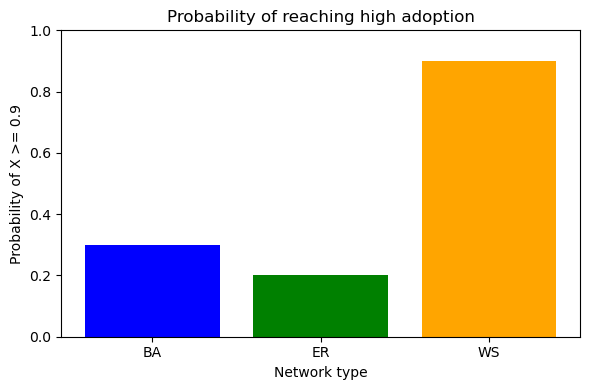

  network_type  high_adoption_prob
0           BA                 0.3
1           ER                 0.2
2           WS                 0.9


In [46]:
def compute_high_adoption_prob(traces_df, threshold=0.9, plot=True):
    """
    Compute probability of reaching high adoption per network.
    """
    final_X_df = traces_df.groupby(["network_type", "trial"]).agg(final_X=("X", "last")).reset_index()
    high_adoption_prob_df = final_X_df.groupby("network_type").apply(
        lambda df: (df["final_X"] >= threshold).mean()
    ).reset_index(name="high_adoption_prob")
    
    if plot:
        plt.figure(figsize=(6,4))
        plt.bar(high_adoption_prob_df["network_type"], high_adoption_prob_df["high_adoption_prob"], color=['blue','green','orange'])
        plt.ylabel(f"Probability of X >= {threshold}")
        plt.xlabel("Network type")
        plt.title("Probability of reaching high adoption")
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
    
    return high_adoption_prob_df

# Usage
high_adoption_probs = compute_high_adoption_prob(traces_df, threshold=0.9)
print(high_adoption_probs)